<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AlbertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from transformers import AutoModel
import copy
from torch.optim import Adam
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer
from typing import List

In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data = pd.read_excel('data_problems_translated.xlsx')


In [4]:
data

,Unnamed: 0,problem_text,topic
0,0,To prove that the sum of the numbers of the ex...,number_theory
1,1,( b) Will the statement of the previous challe...,number_theory
2,2,The quadratic three-member graph with the coef...,polynoms
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs
...,...,...,...
5268,5268,Can the number n! end with the figures of 76.0...,number_theory
5269,5269,Find all natural m and n for which m! + 12 = n2.,number_theory
5270,5270,"The correct 5,000-column has a 2001 vertebrate...",dirichlet
5271,5271,Find the maximum number N for which there are ...,number_theory


In [5]:
headers = data.columns.tolist()
headers

['Unnamed: 0', 'problem_text', 'topic']

In [6]:
data = data.dropna()

In [7]:
num = data['Unnamed: 0']
task = data['problem_text']
theme = data['topic']

In [8]:
theme.unique()

array(['number_theory', 'polynoms', 'combinatorics', 'graphs', 'geometry',
       'invariant', 'dirichlet'], dtype=object)

In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(theme)
labels_encoded

array([5, 5, 6, ..., 1, 5, 0])

In [10]:
type(task.to_list())

list

In [11]:
print(task.isnull().sum())

0


In [32]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
encoding = tokenizer(task.tolist(), padding=True, truncation=True, max_length=64, return_tensors="pt")

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], torch.tensor(labels_encoded))

loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [34]:
labels_tensor = dataset.tensors[-1]
unique_labels = labels_tensor.unique()
num_unique_labels = unique_labels.numel()

print(f"unique_labels: {unique_labels}")
print(f"num_unique_labels: {num_unique_labels}")

unique_labels: tensor([0, 1, 2, 3, 4, 5, 6], dtype=torch.int32)
num_unique_labels: 7


In [35]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_labels: int):
        super().__init__()
        
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        return logits

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [36]:
def freeze_backbone_function(model: TransformerClassificationModel, state):
    for param in model.backbone.parameters():
        param.requires_grad = state
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [37]:
import copy

def train_transformer(model, train_loader, epochs, learning_rate=1e-5, freeze_backbone=True):
    if freeze_backbone:
        freeze_backbone_function(model, False)
    else:
        freeze_backbone_function(model, True)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    model
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            input_ids, attention_mask, labels = [b for b in batch]
            labels = labels.type(torch.LongTensor)
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}")
        
    return model

In [27]:
albert_base_v2_model = TransformerClassificationModel('albert-base-v2', num_labels=len(label_encoder.classes_))
albert_base_v2__finetuned_with_freezed_backbone = train_transformer(copy.deepcopy(albert_base_v2_model), loader, epochs=1, learning_rate=2e-5, freeze_backbone=True)

Epoch 1, Average Loss: 1.5957879612367987


In [ ]:
albert_base_v2_full_finetuned = train_transformer(copy.deepcopy(albert_base_v2_model), loader, epochs=5, learning_rate=2e-5, freeze_backbone=False)

Epoch 1, Average Loss: 1.2134473686903466
Epoch 2, Average Loss: 0.9837816394554365
Epoch 3, Average Loss: 1.1187681000108352
Epoch 4, Average Loss: 1.5629804551872957
Epoch 5, Average Loss: 1.3990499067686686


### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [38]:
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2', num_labels=len(label_encoder.classes_))

rubert_tiny_finetuned_with_freezed_backbone = train_transformer(copy.deepcopy(rubert_tiny_transformer_model), loader, epochs=5, learning_rate=2e-5, freeze_backbone=True)


Epoch 1, Average Loss: 1.656508036472622
Epoch 2, Average Loss: 1.5652725922174315
Epoch 3, Average Loss: 1.5320047270464192
Epoch 4, Average Loss: 1.5030334109868981
Epoch 5, Average Loss: 1.4762337388486326


In [40]:
rubert_tiny_full_finetuned = train_transformer(copy.deepcopy(rubert_tiny_transformer_model), loader, epochs=2, learning_rate=2e-5, freeze_backbone=False)

Epoch 1, Average Loss: 1.2463292375421922
Epoch 2, Average Loss: 0.9797359273380734


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [41]:
### YOUR CODE IS HERE (probably, similar on the previous step)

math_bert_transformer_model = TransformerClassificationModel('tbs17/MathBert', num_labels=len(label_encoder.classes_))

math_bert_transformer_finetuned_with_freezed_backbone = train_transformer(copy.deepcopy(math_bert_transformer_model), loader, epochs=2, learning_rate=2e-5, freeze_backbone=True)


Epoch 1, Average Loss: 1.6440125365735188
Epoch 2, Average Loss: 1.5501683952121366


In [42]:
math_bert_transformer_full_finetuned = train_transformer(copy.deepcopy(math_bert_transformer_model), loader, epochs=2, learning_rate=2e-5, freeze_backbone=False)

Epoch 1, Average Loss: 1.2985568402583259
Epoch 2, Average Loss: 1.0402047829051915


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [43]:
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer

def draw_first_layer_attention_maps(attention_head_ids: List[int], text: str, model: TransformerClassificationModel):
    tokenizer = AutoTokenizer.from_pretrained(model.backbone.name_or_path)
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"]
    
    model.eval()
    with torch.no_grad():
        outputs = model.backbone(input_ids=input_ids, output_attentions=True)
        first_layer_attentions = outputs.attentions[0]
    
    num_heads = first_layer_attentions.size(1)
    fig, axes = plt.subplots(1, len(attention_head_ids), figsize=(20, 10))
    if len(attention_head_ids) == 1:
        axes = [axes]  
    for idx, head_id in enumerate(attention_head_ids):
        if head_id < num_heads:
            ax = axes[idx]
            attention = first_layer_attentions[0, head_id].cpu().numpy()
            ax.matshow(attention, cmap='viridis')
            ax.set_title(f'Head {head_id}')
            ax.set_xlabel('Tokens')
            ax.set_ylabel('Tokens')
            ax.set_xticks(range(len(input_ids[0])))
            ax.set_xticklabels(tokenizer.convert_ids_to_tokens(input_ids[0]), rotation=90)
            ax.set_yticks(range(len(input_ids[0])))
            ax.set_yticklabels(tokenizer.convert_ids_to_tokens(input_ids[0]))
        else:
            print(f"{head_id} is out of range, {num_heads}  heads.")
    plt.tight_layout()
    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


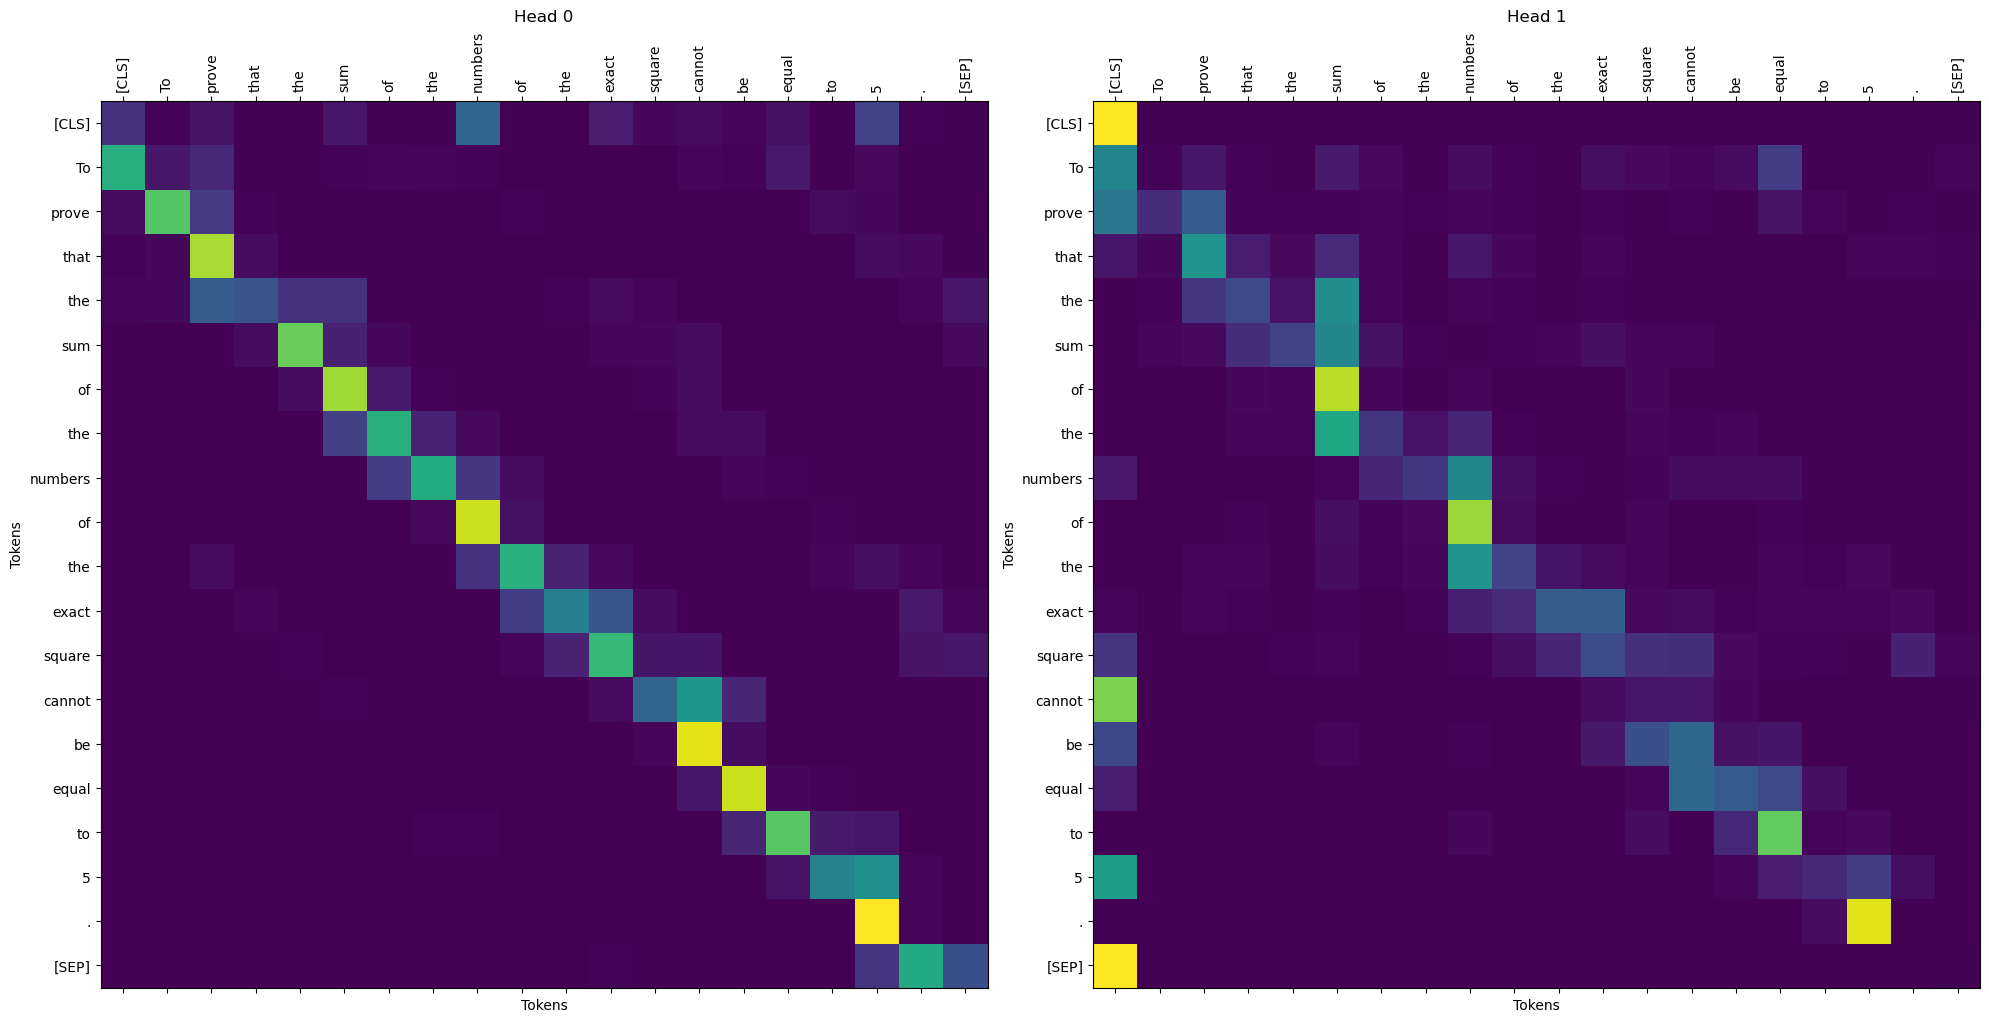

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


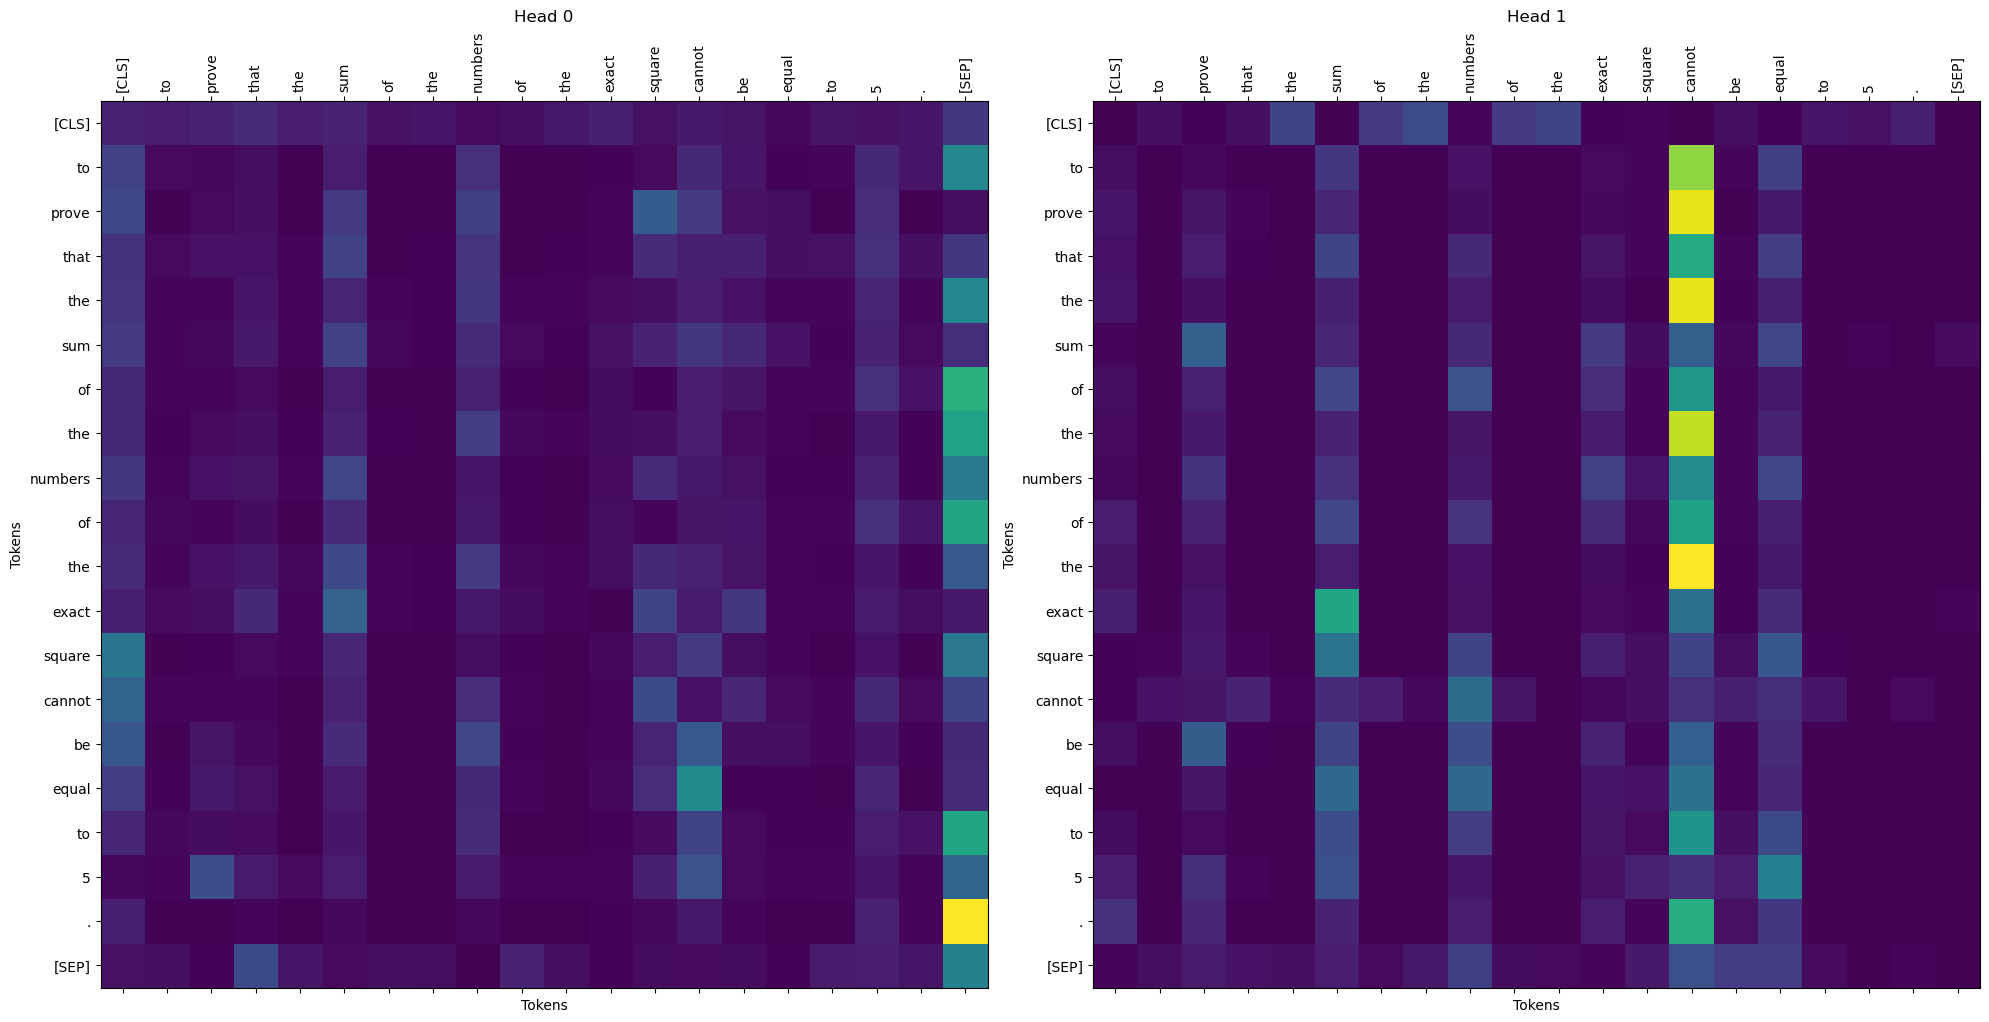

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


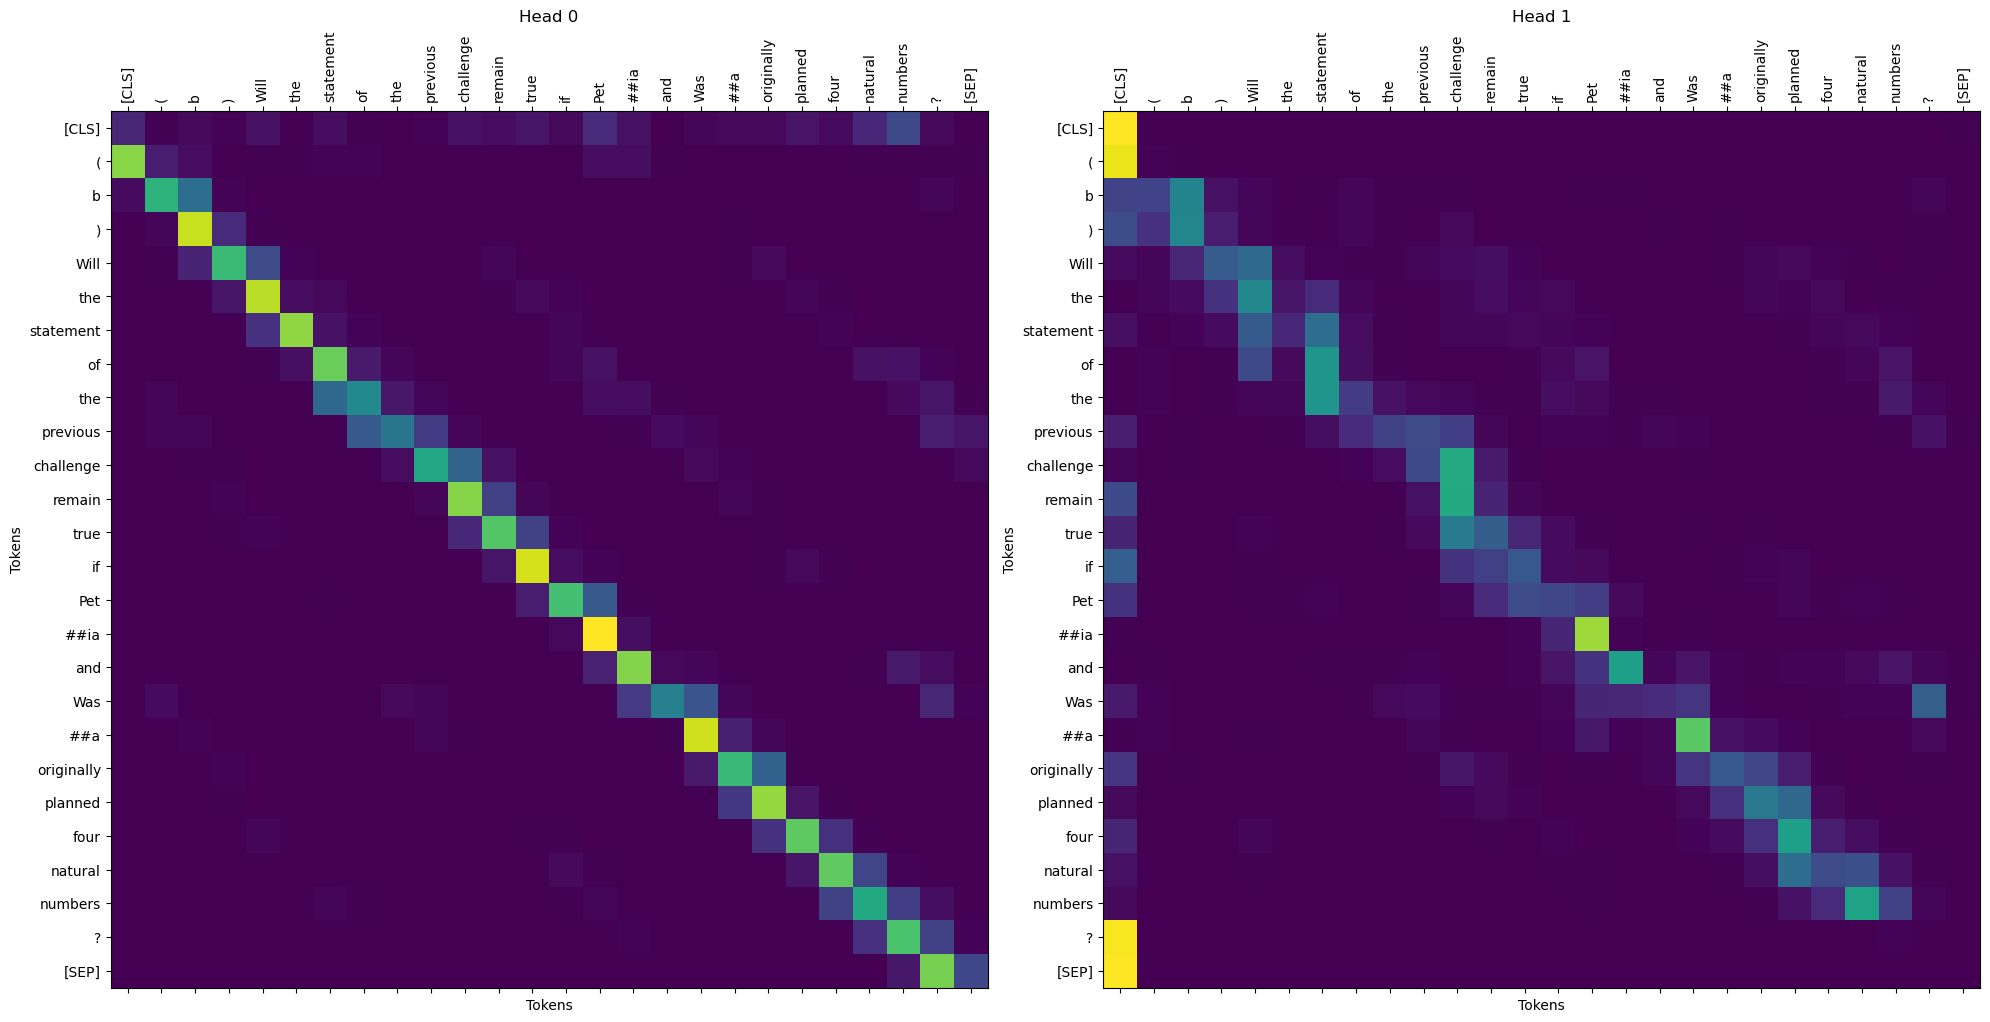

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


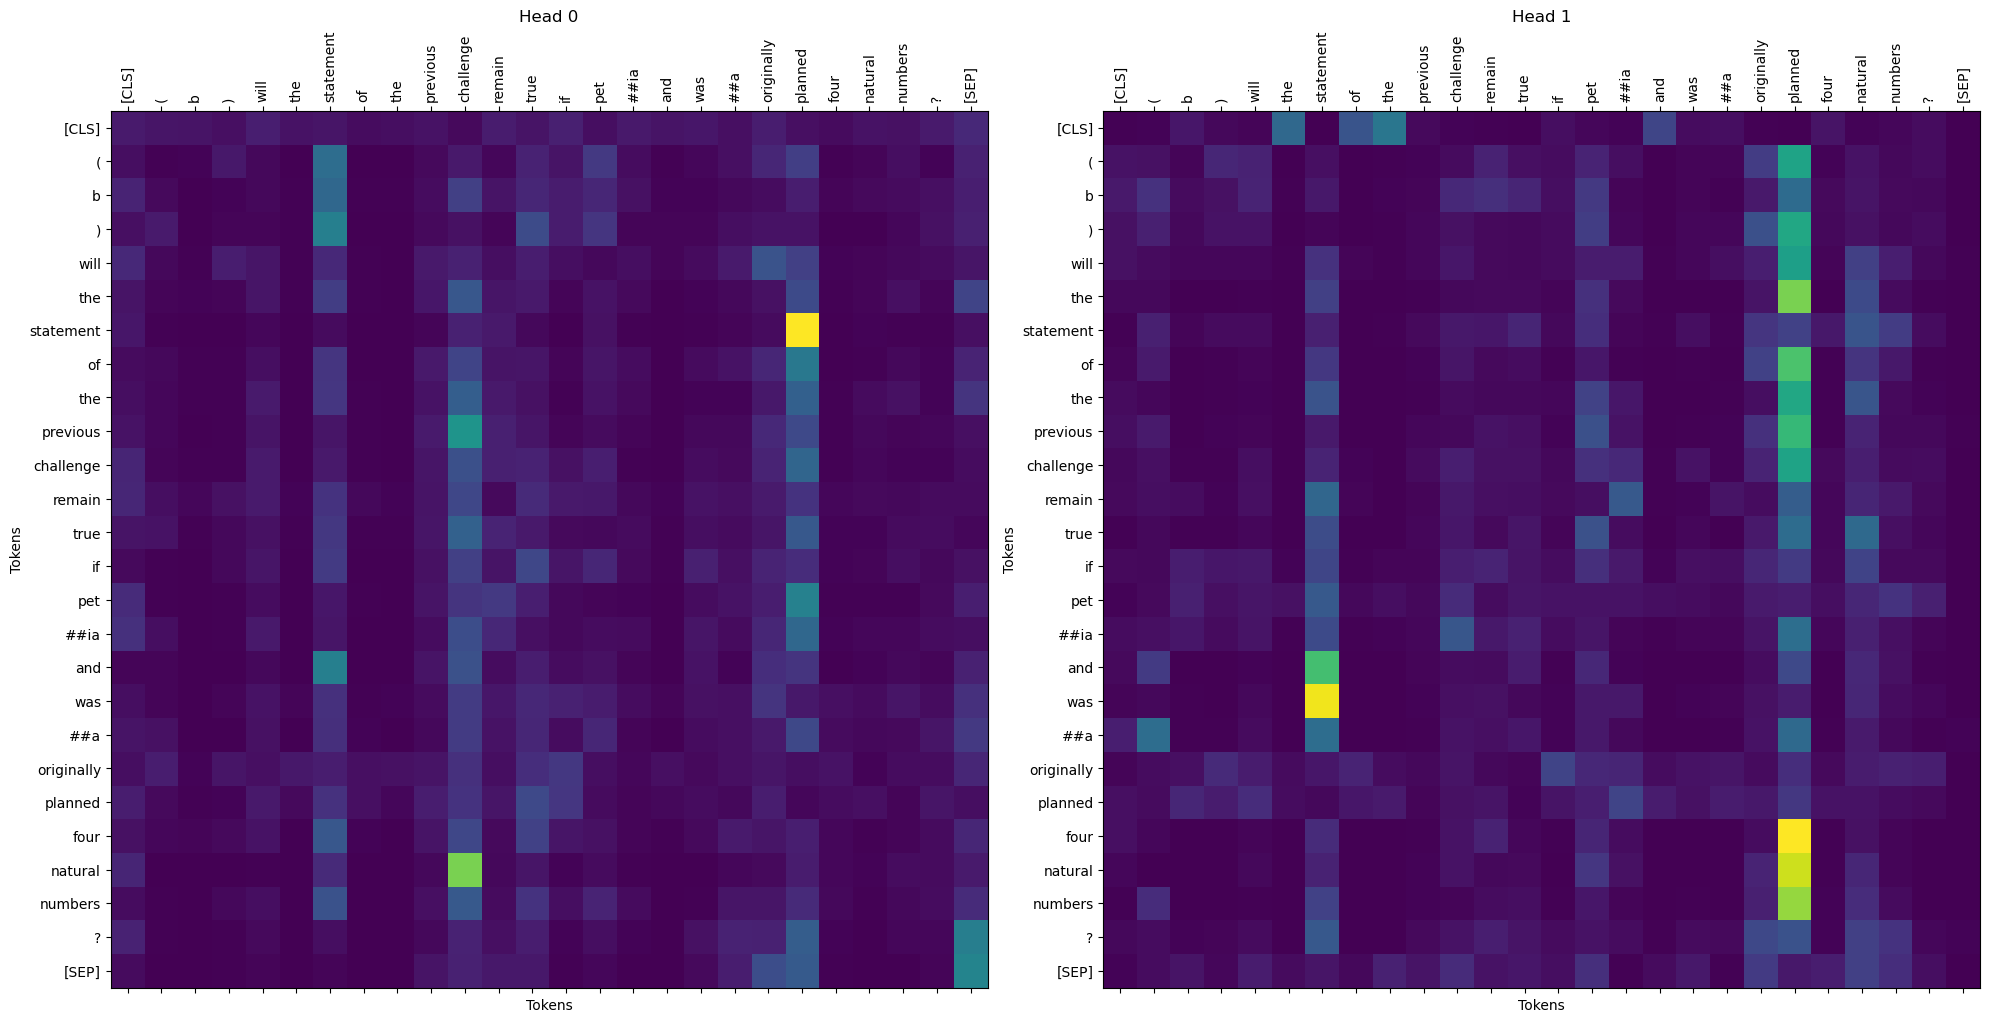

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


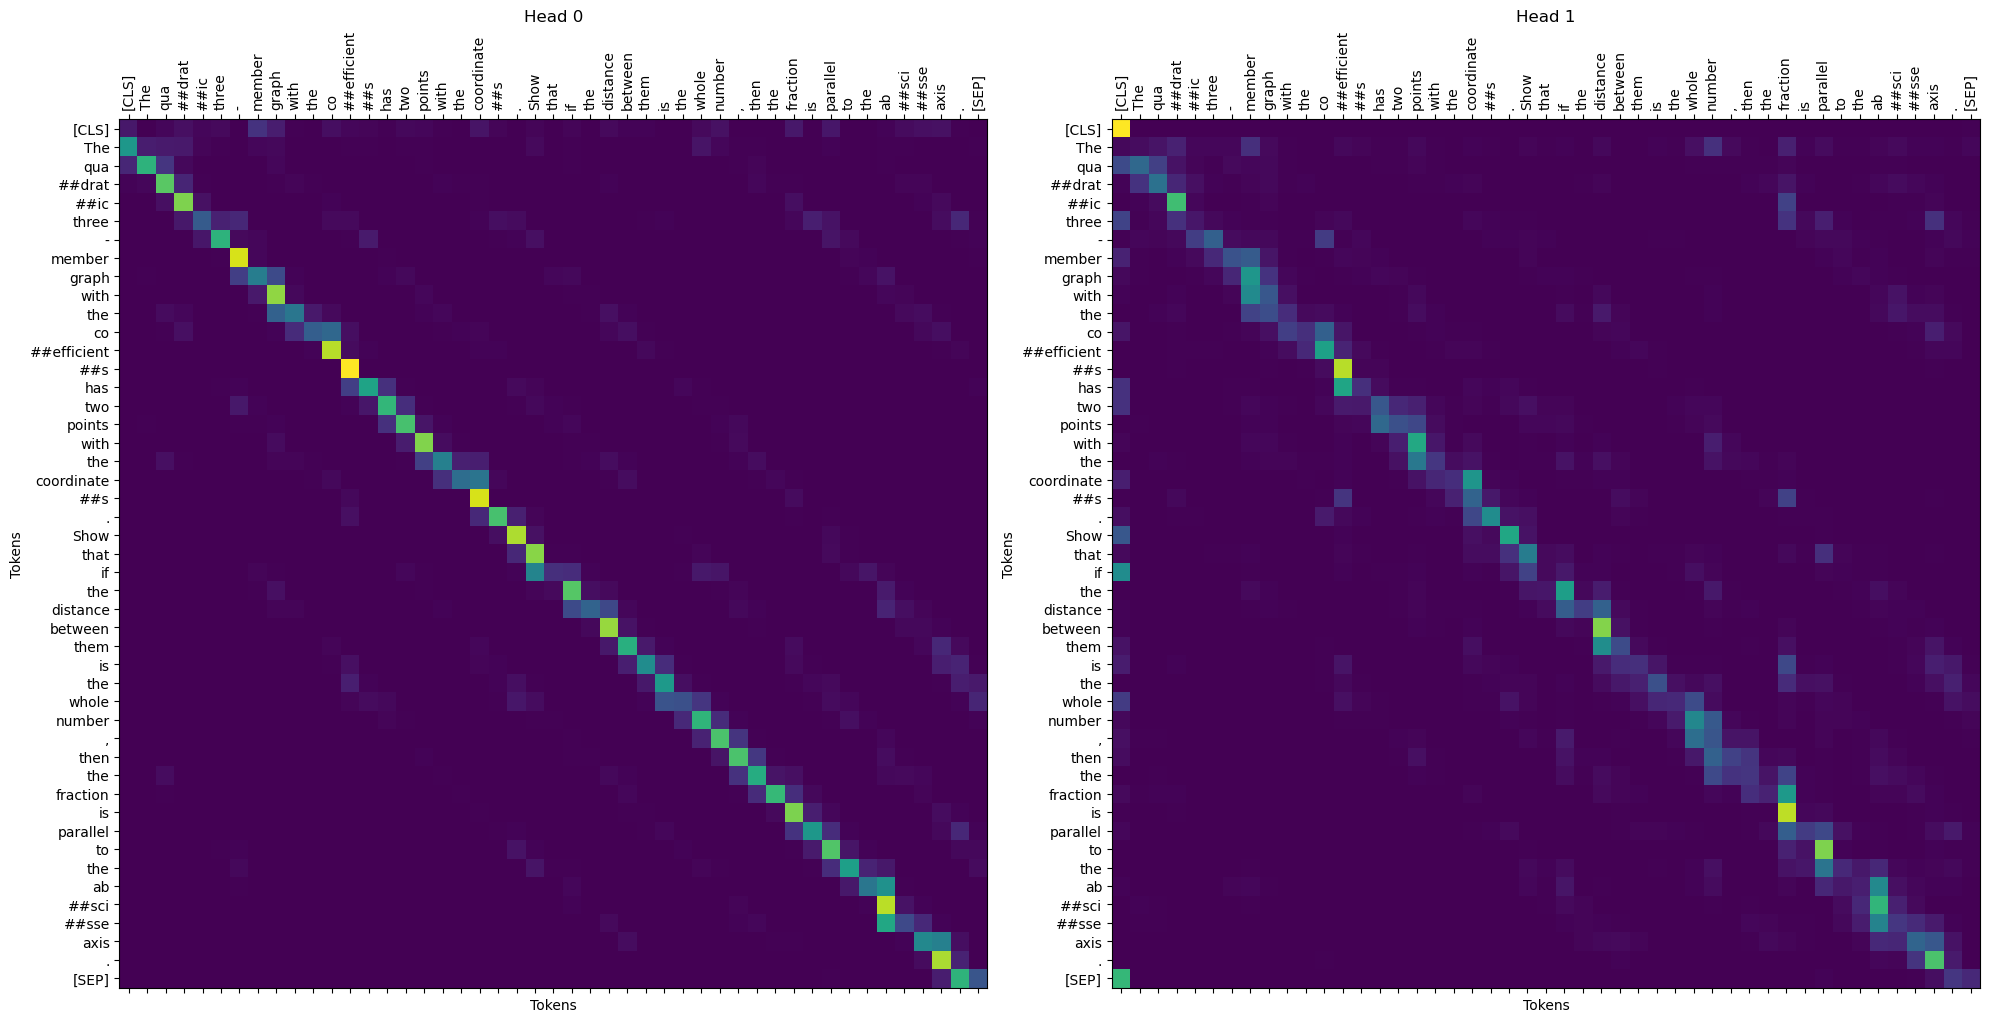

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


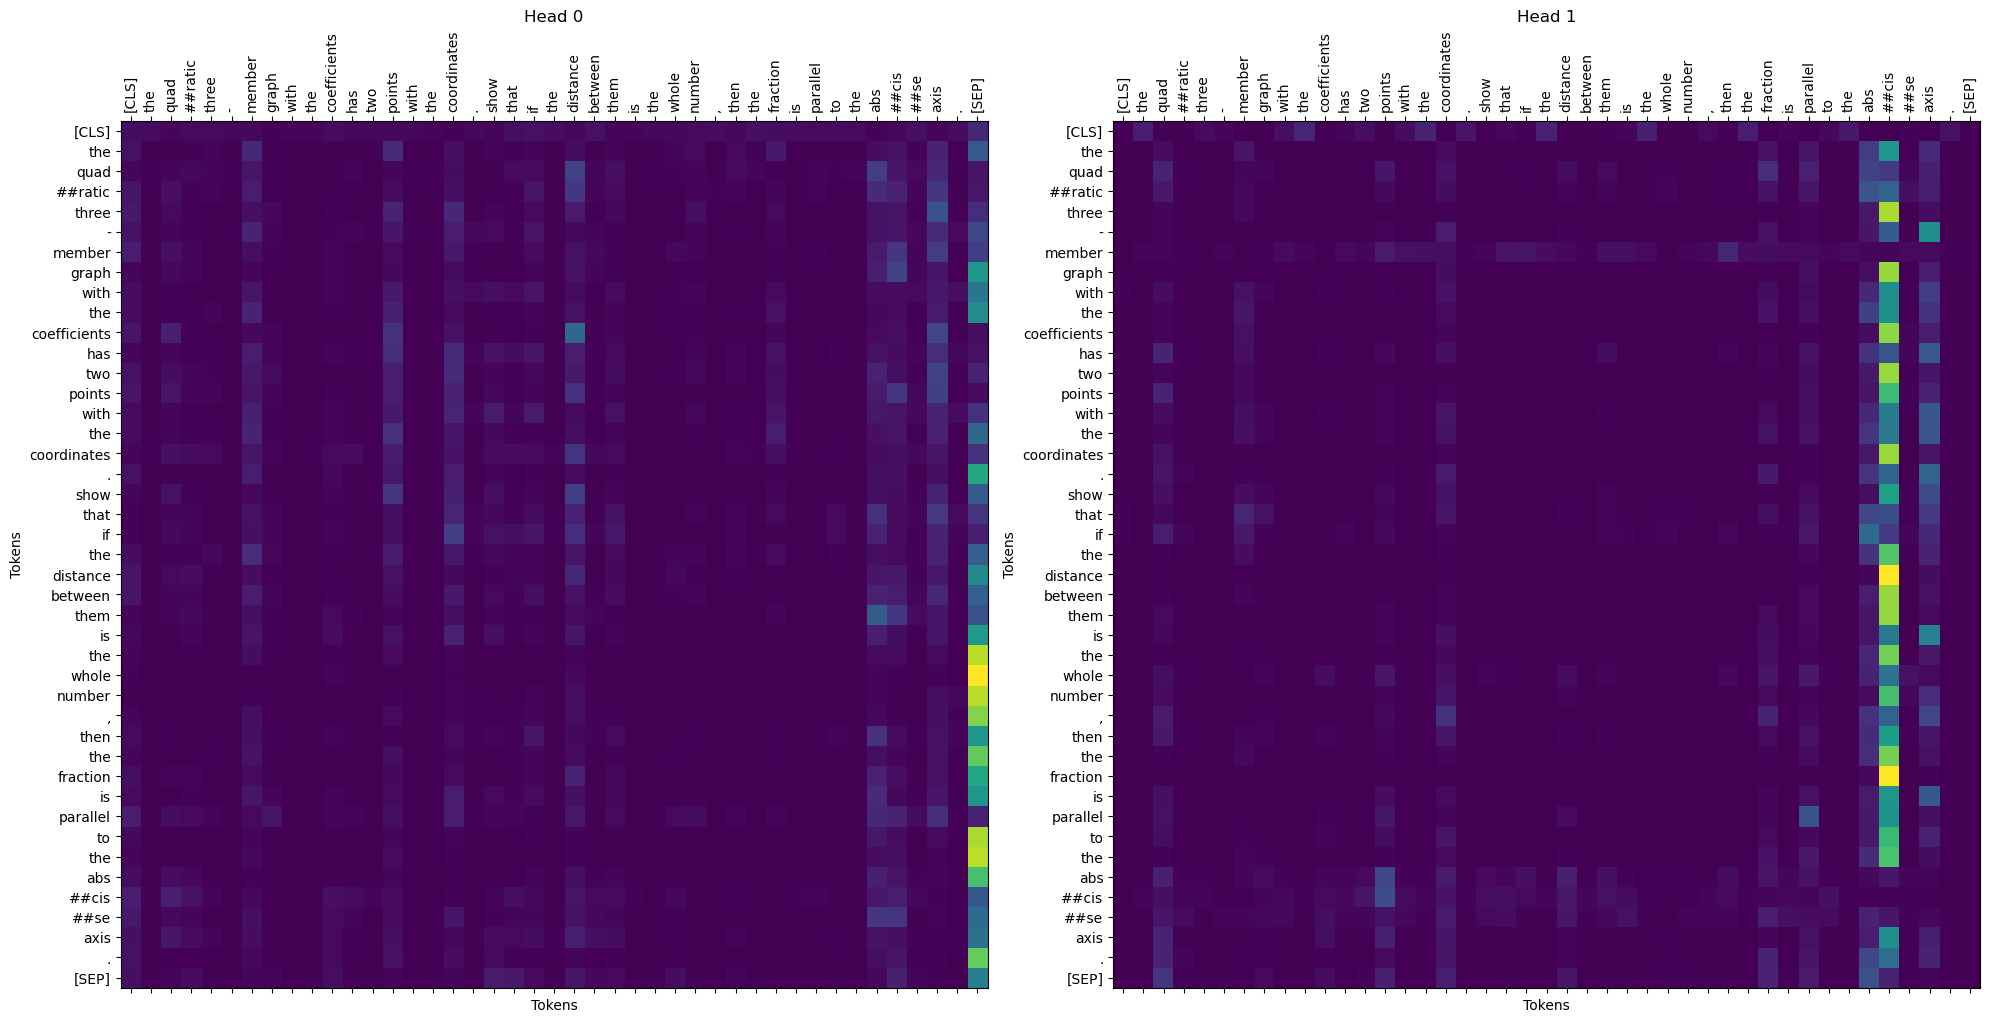

In [44]:
### YOUR CODE IS HERE
texts_to_analyze = data['problem_text'].iloc[:3].tolist()

for text in texts_to_analyze:
    
    #draw_first_layer_attention_maps([0, 1], text, albert_base_v2_model)
    draw_first_layer_attention_maps([0, 1], text, rubert_tiny_transformer_model)
    draw_first_layer_attention_maps([0, 1], text, math_bert_transformer_model)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


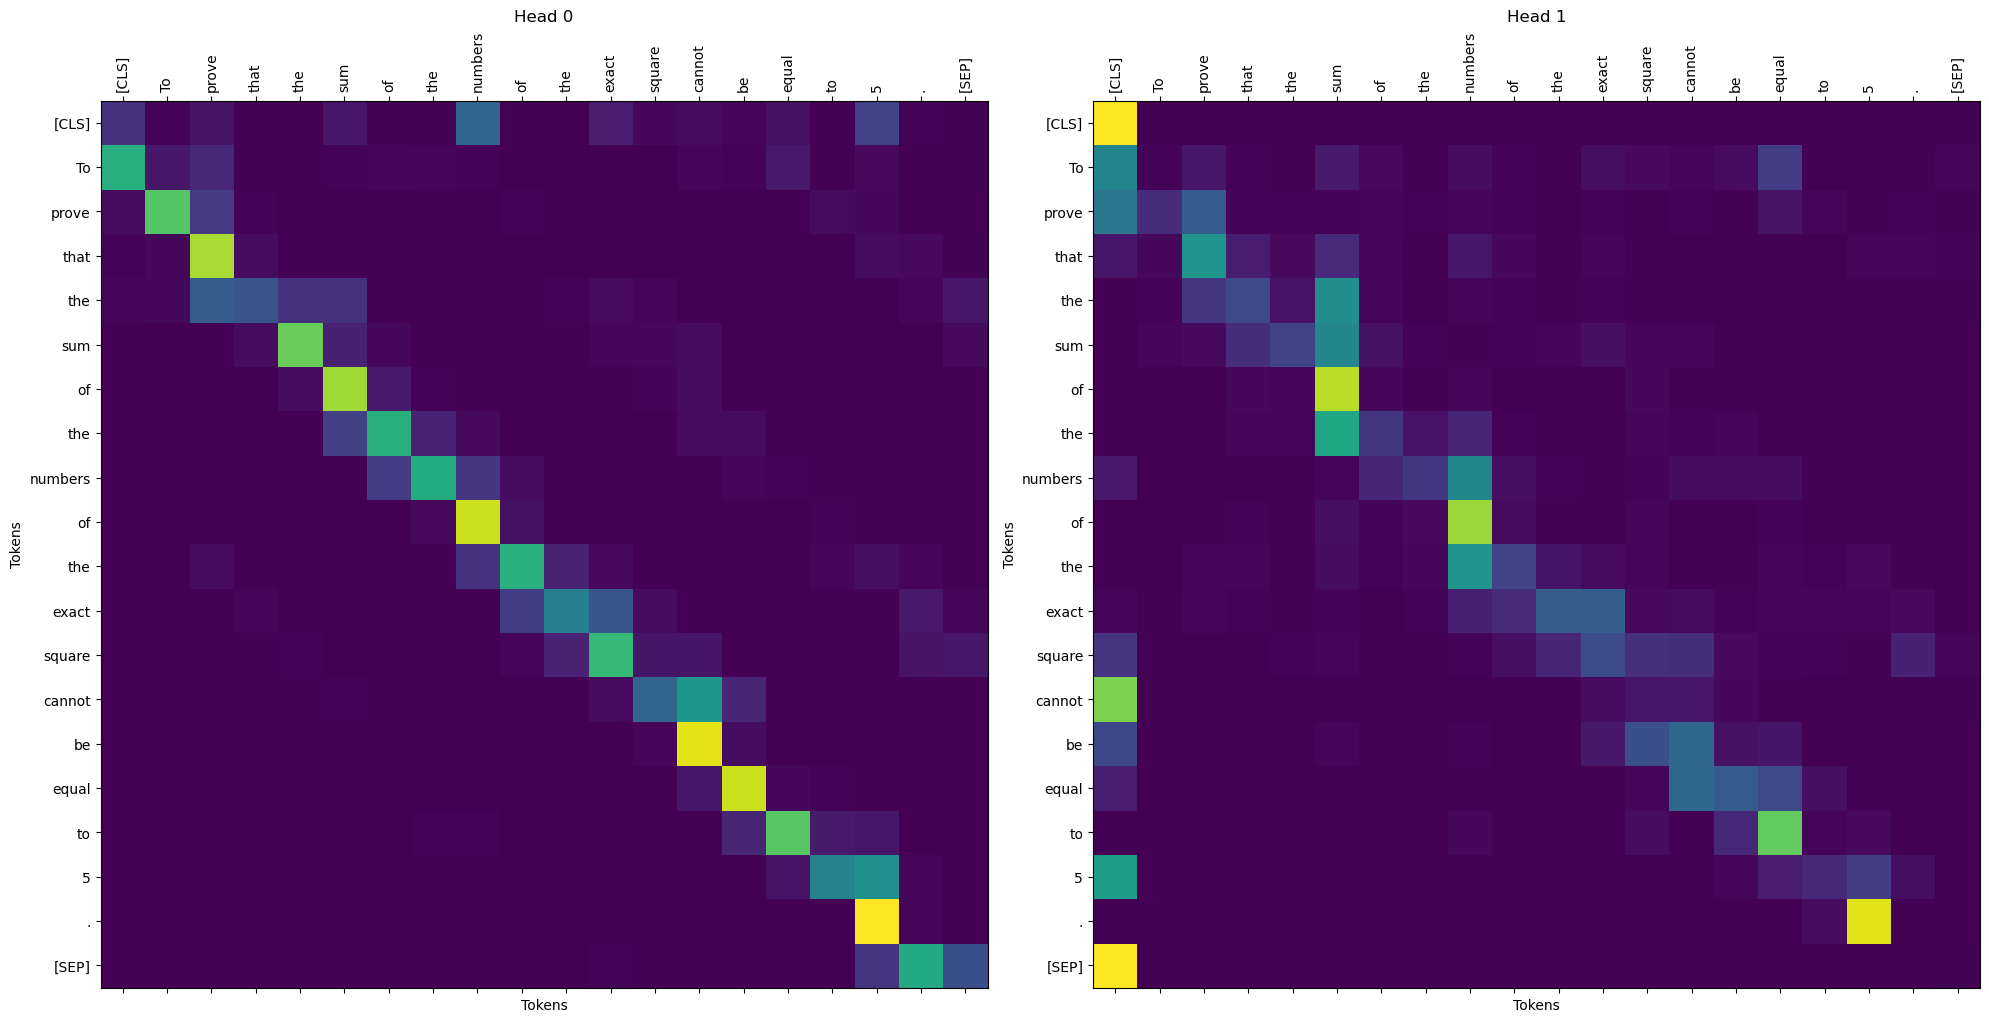

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


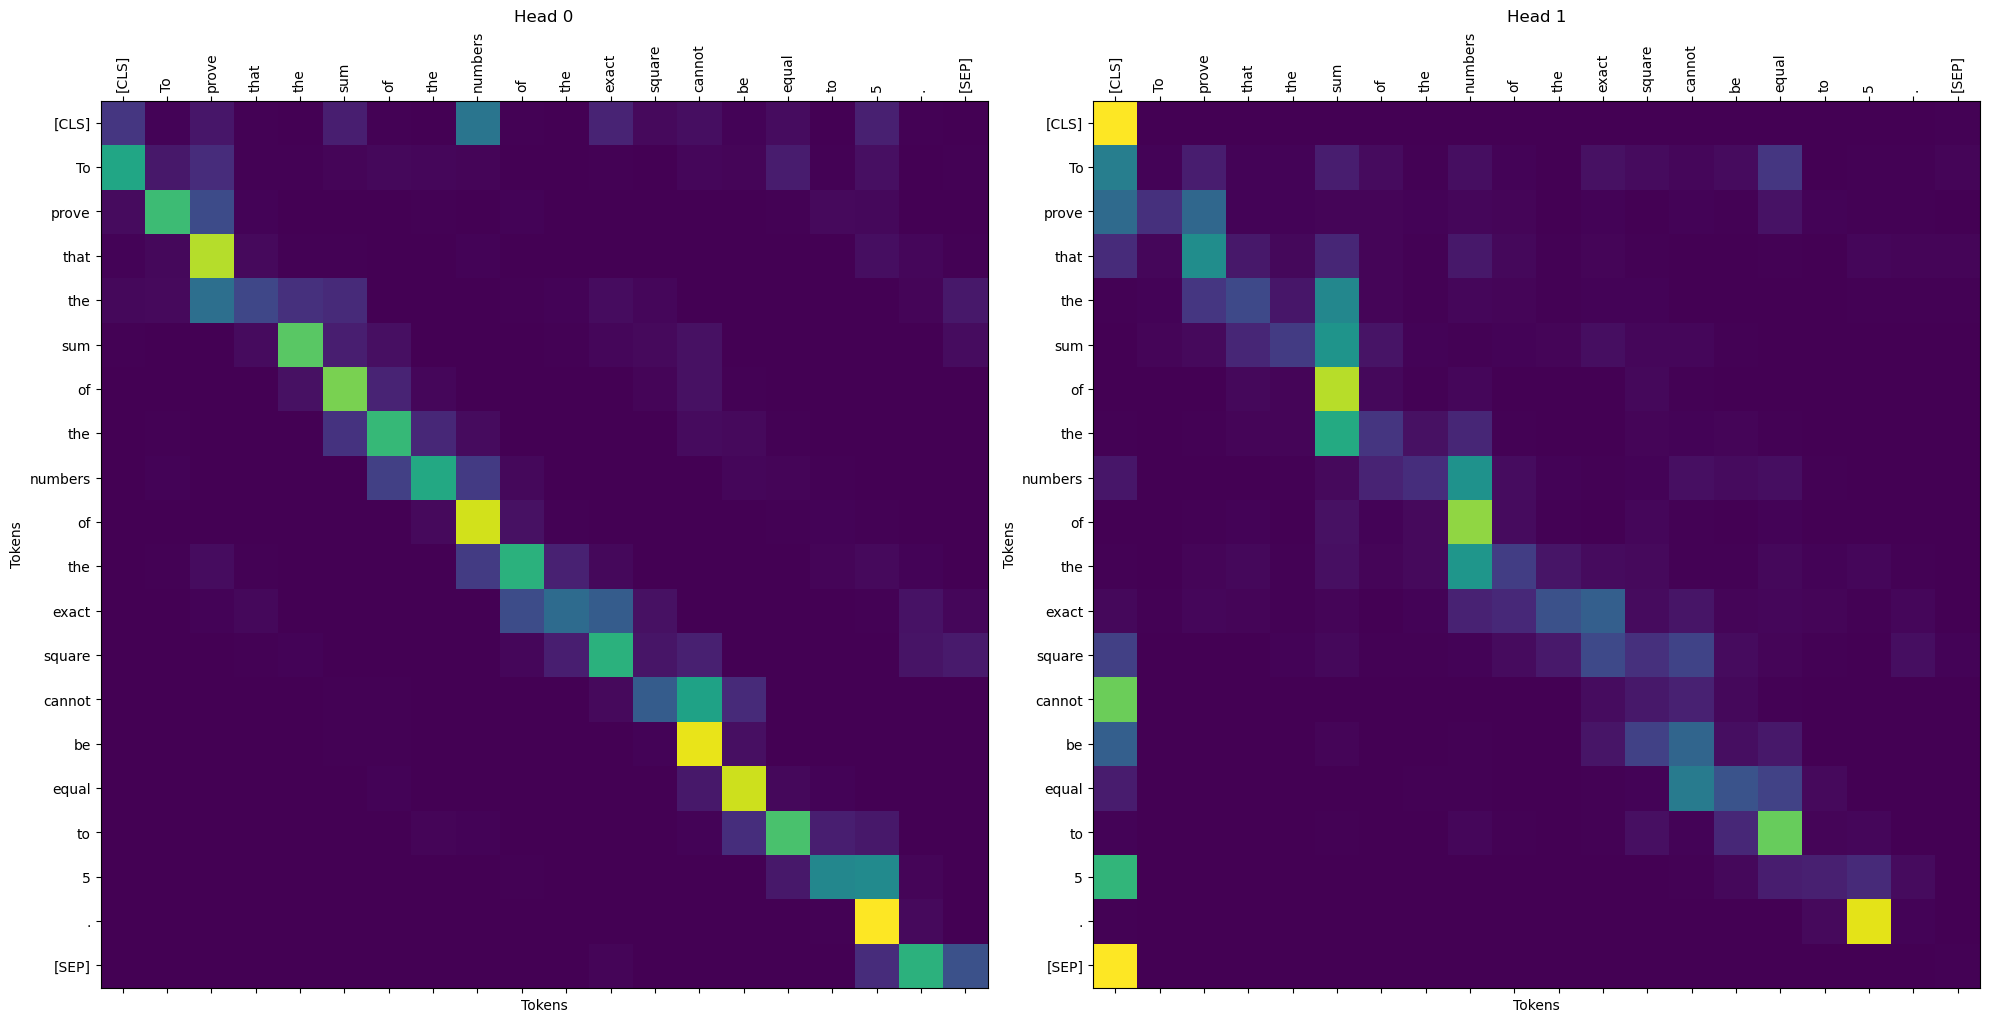

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


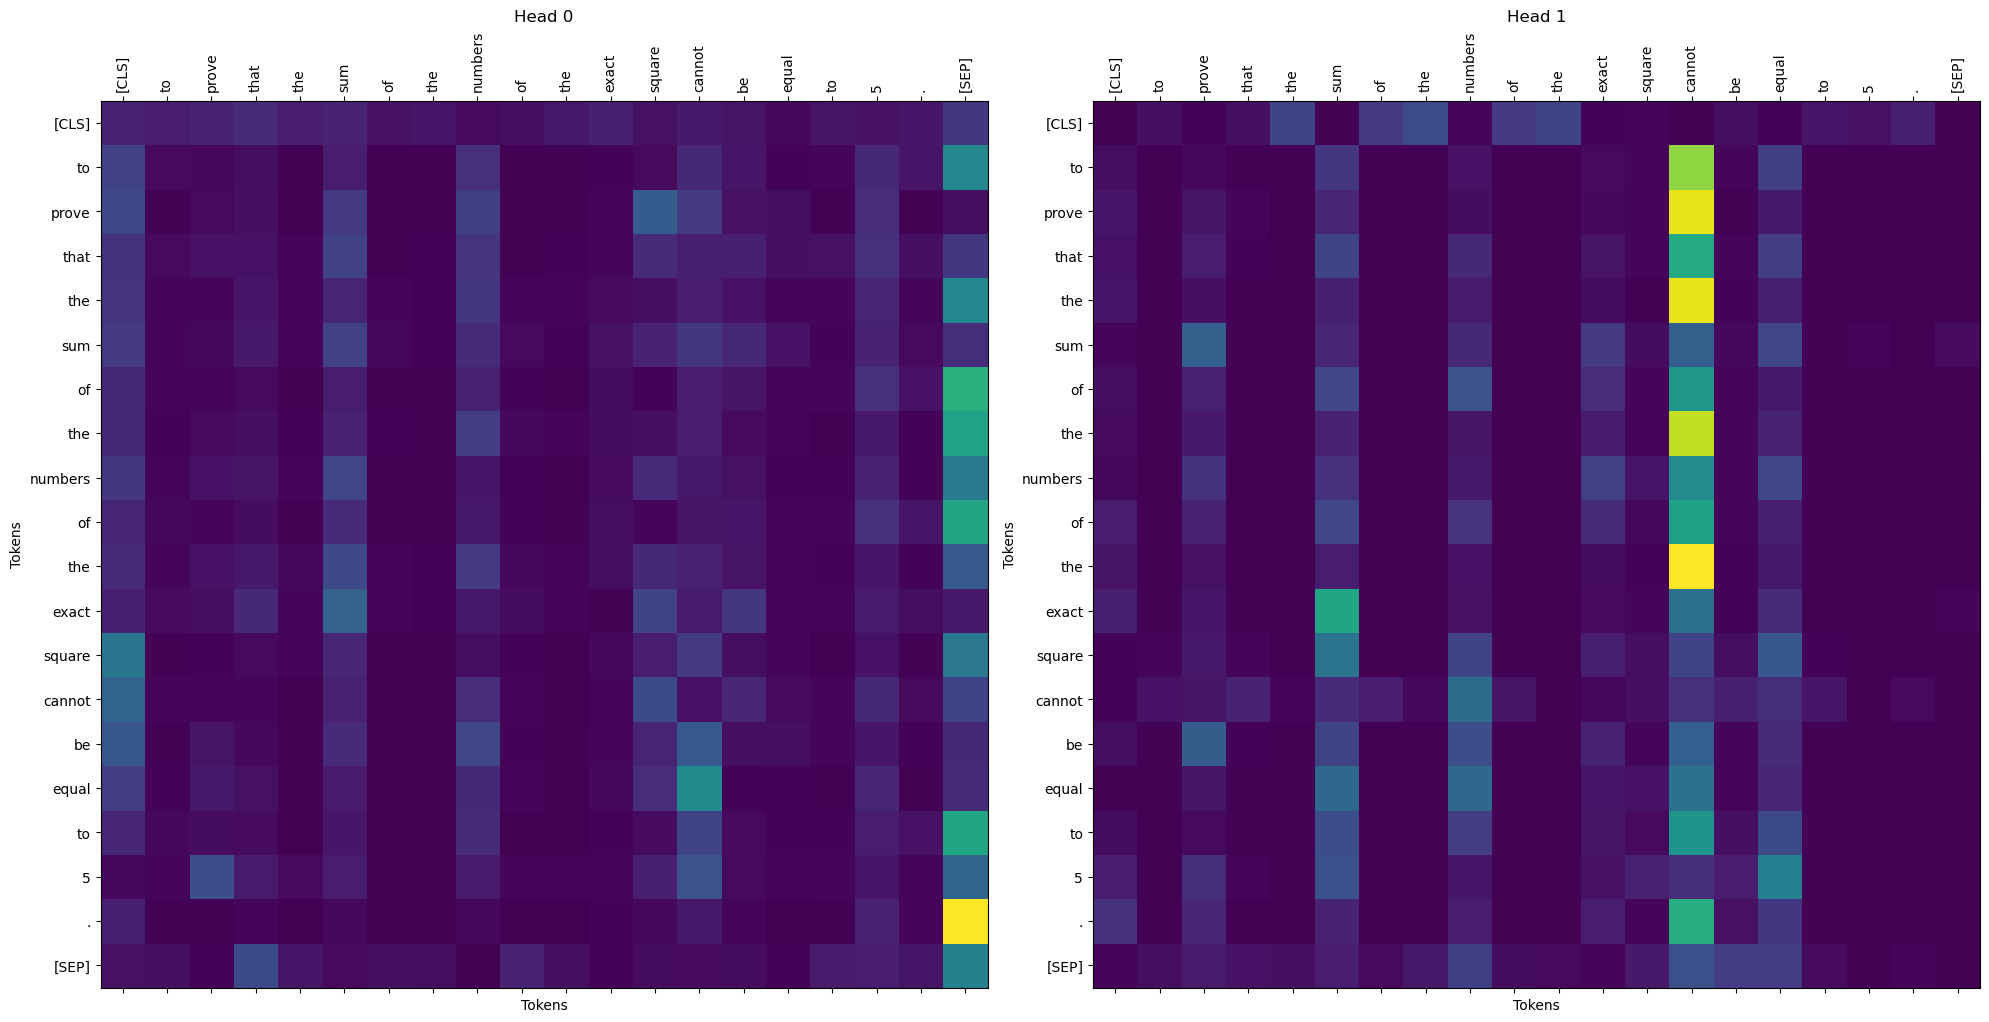

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


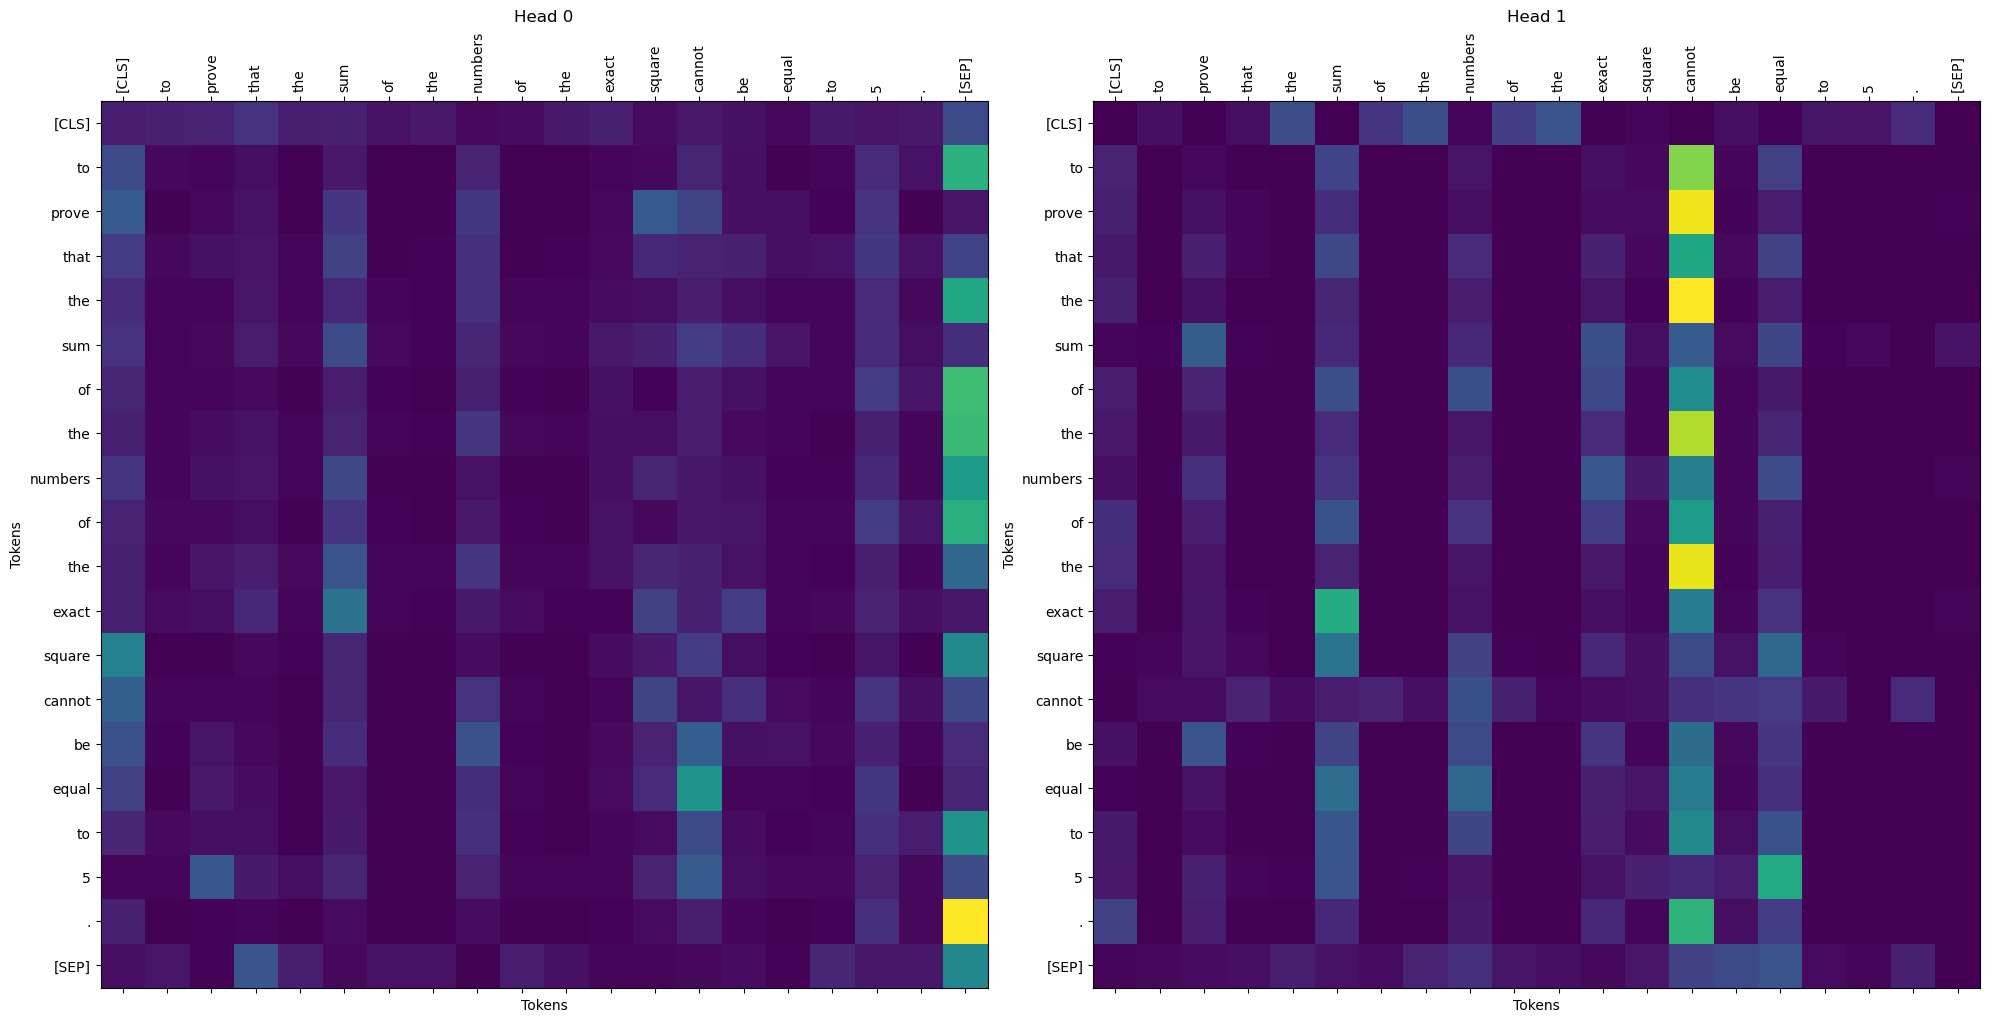

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


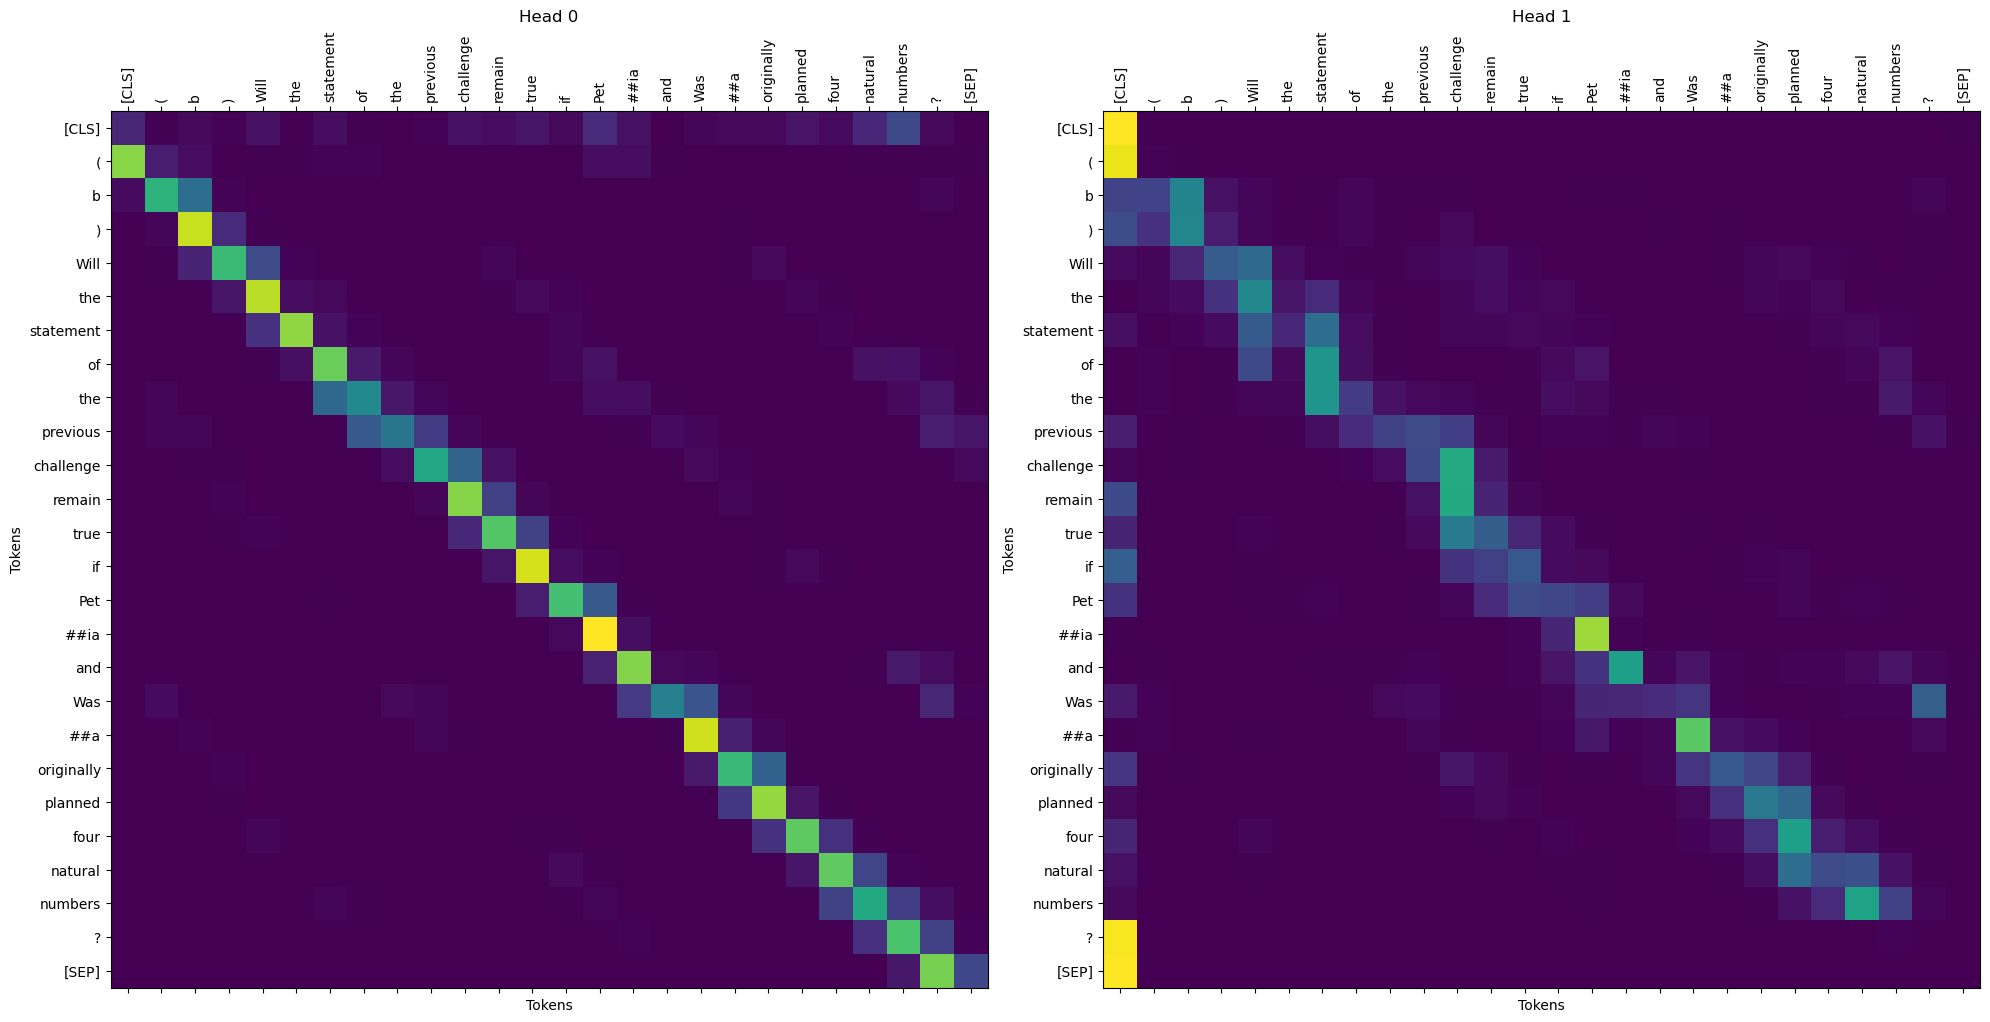

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


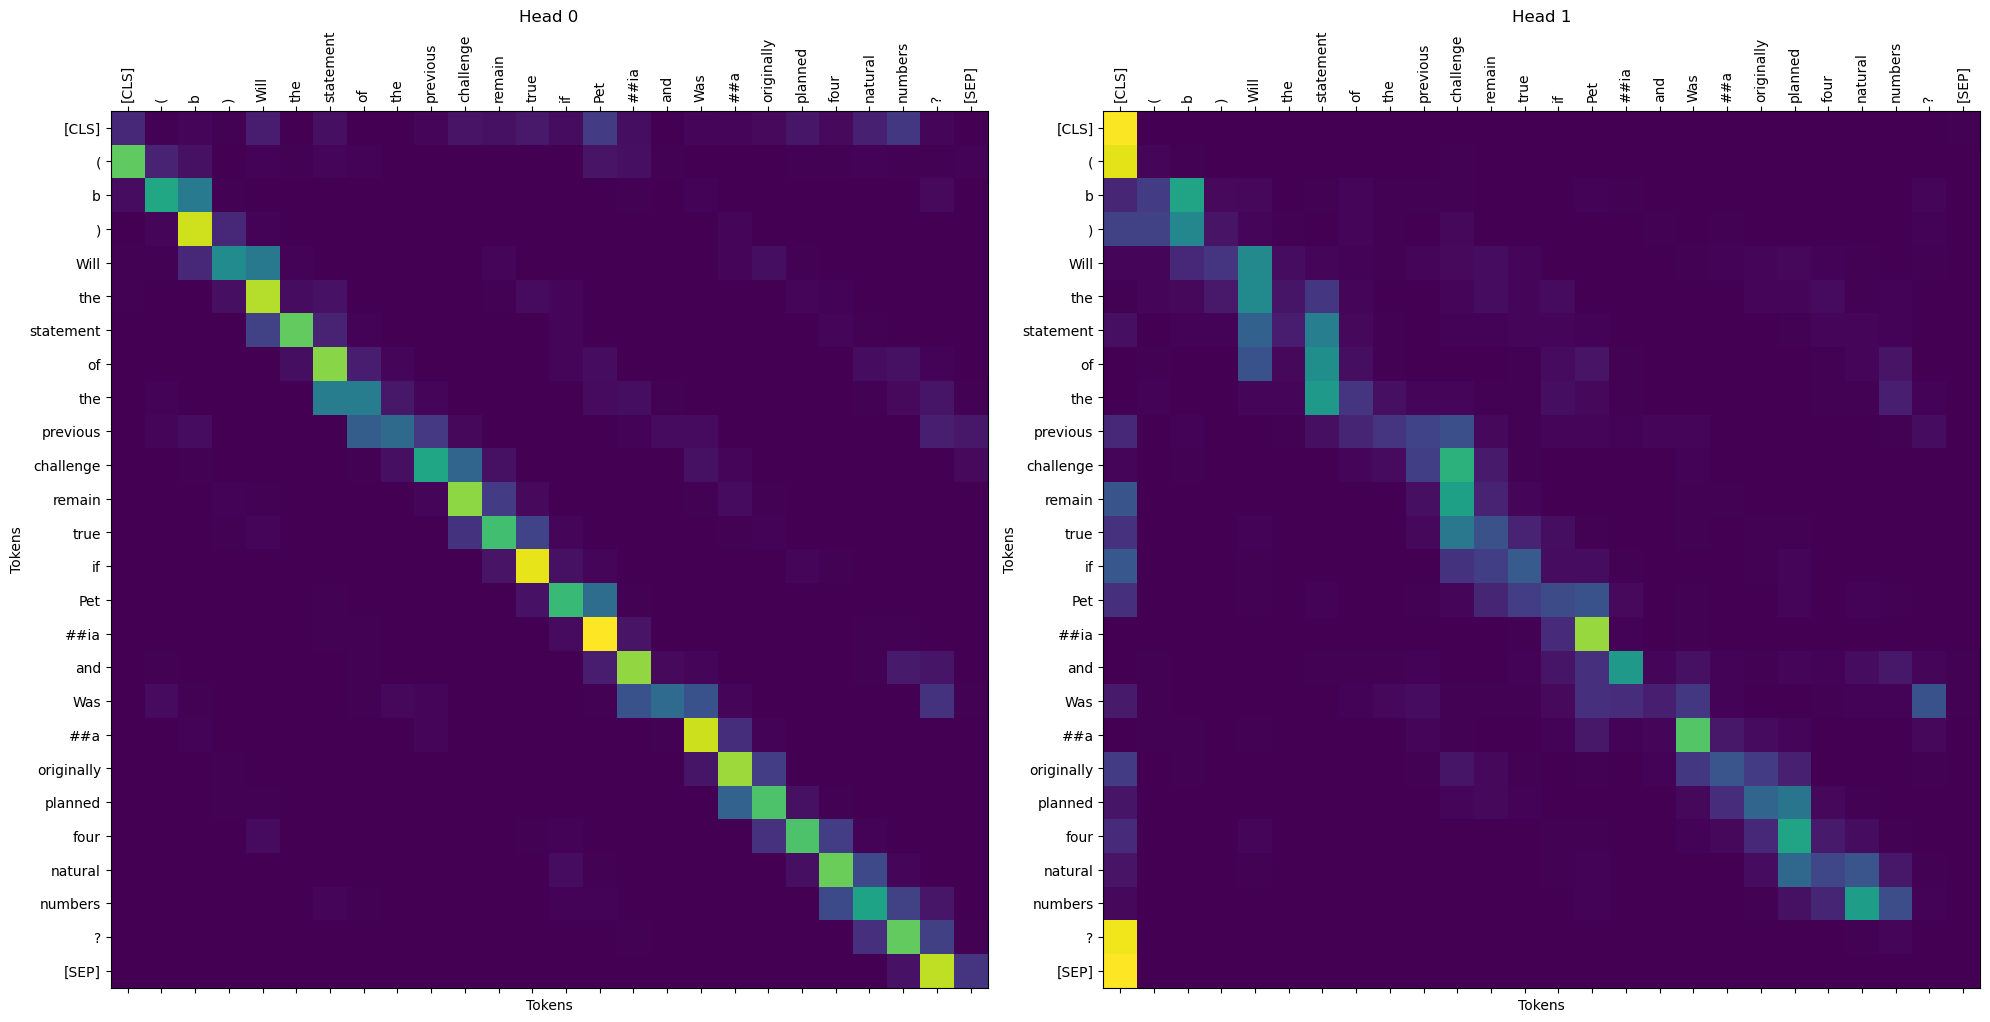

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


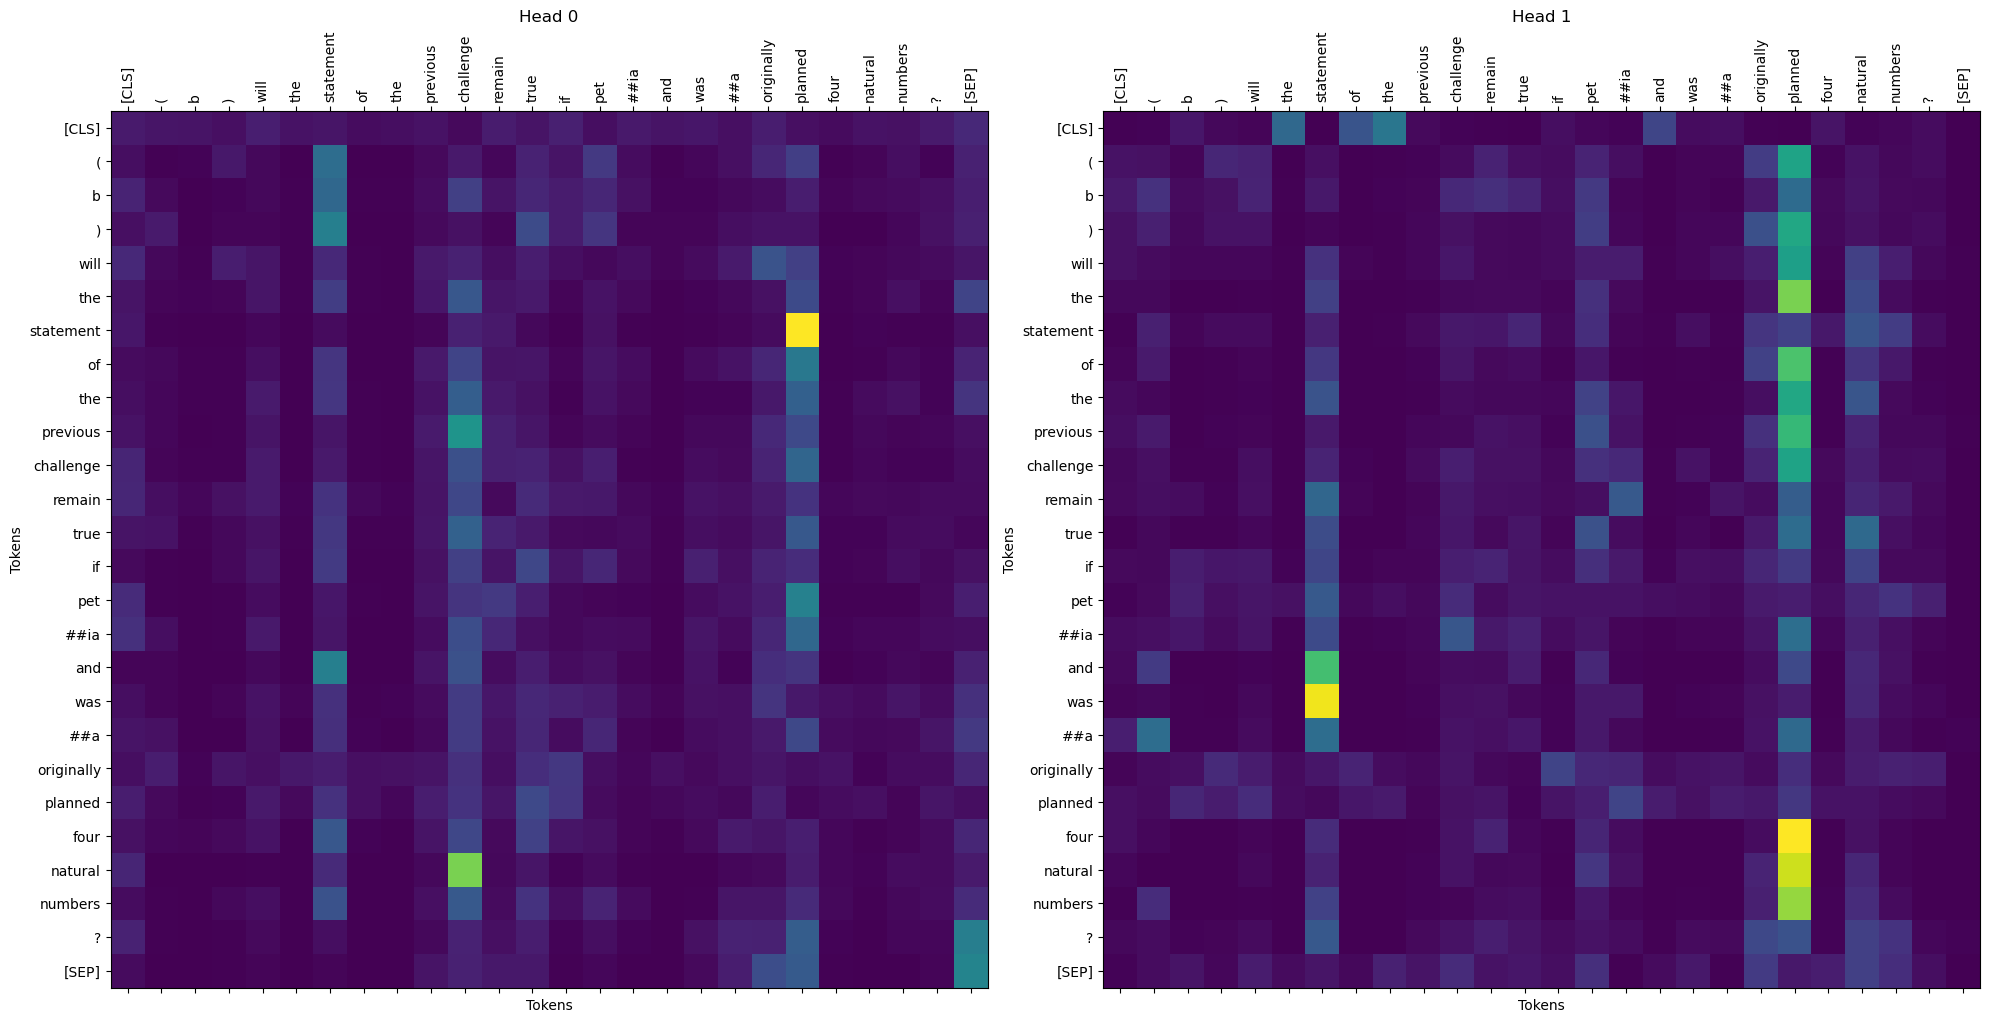

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


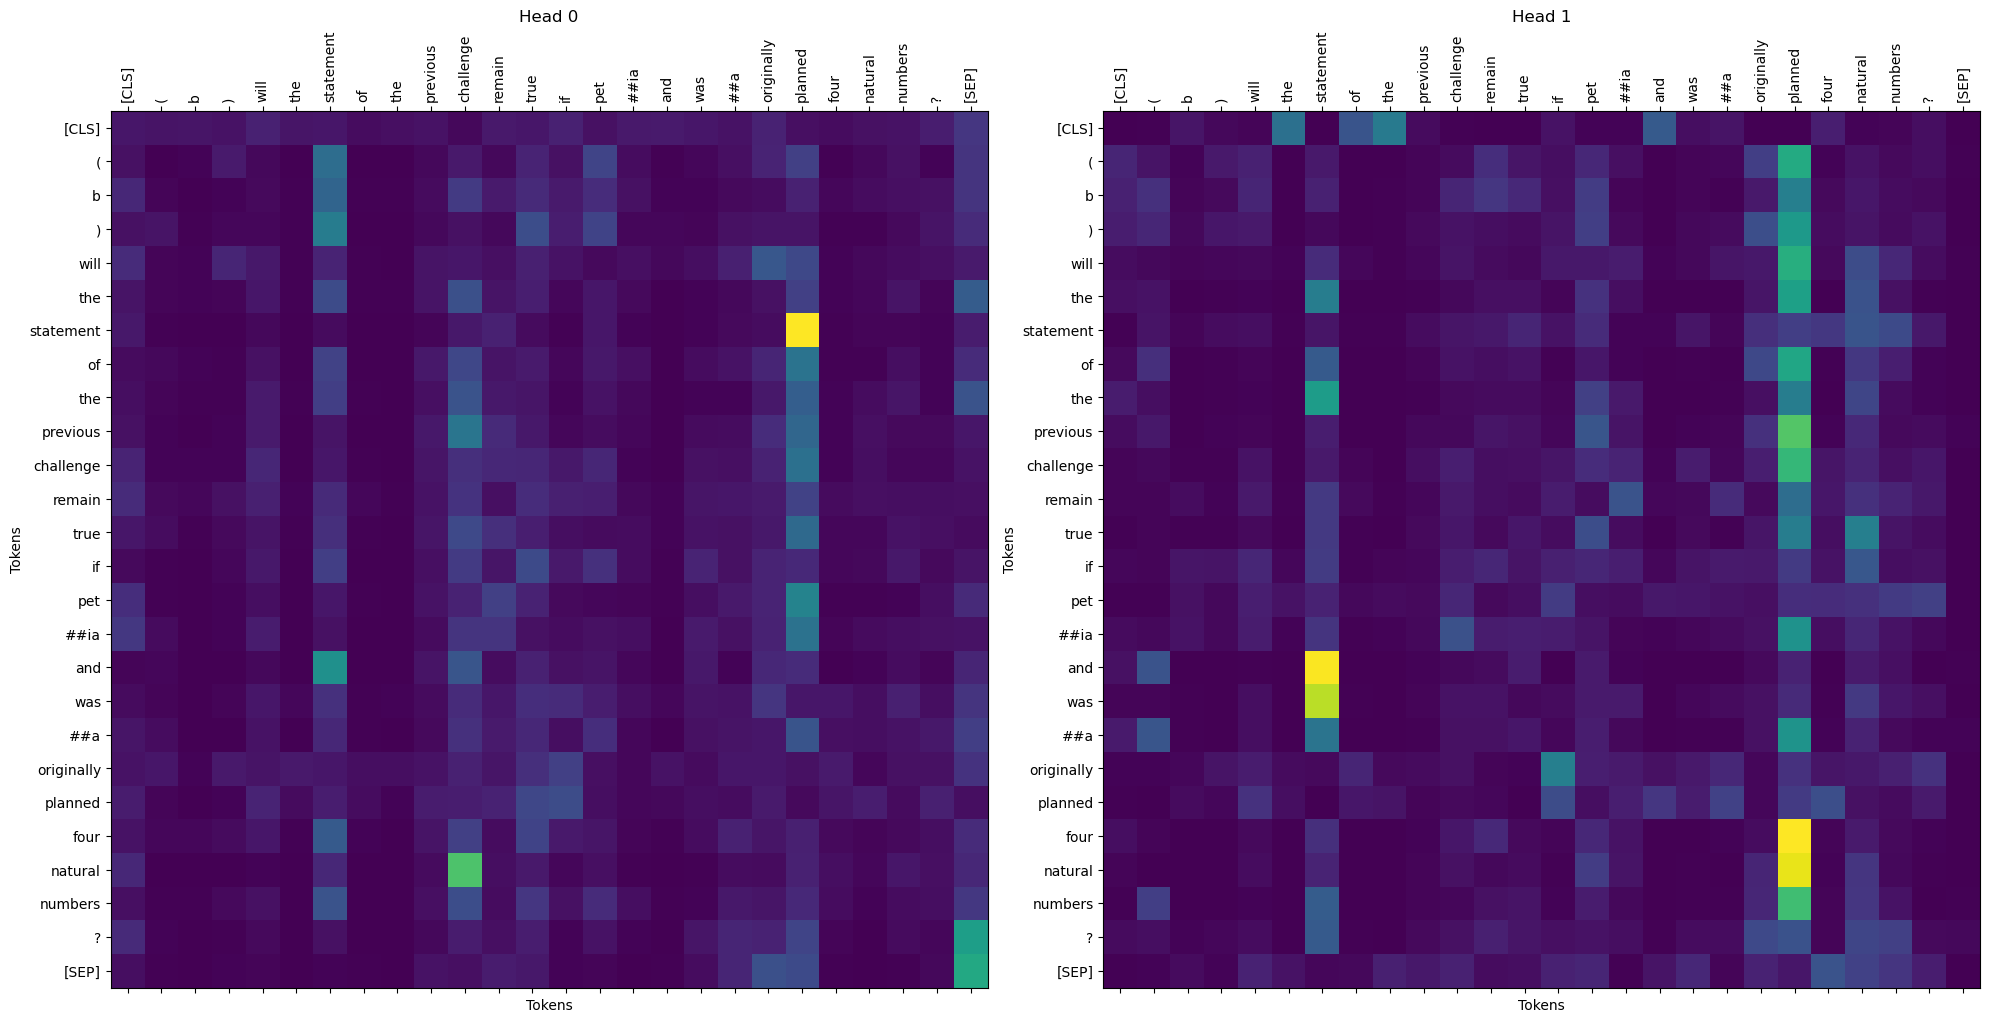

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


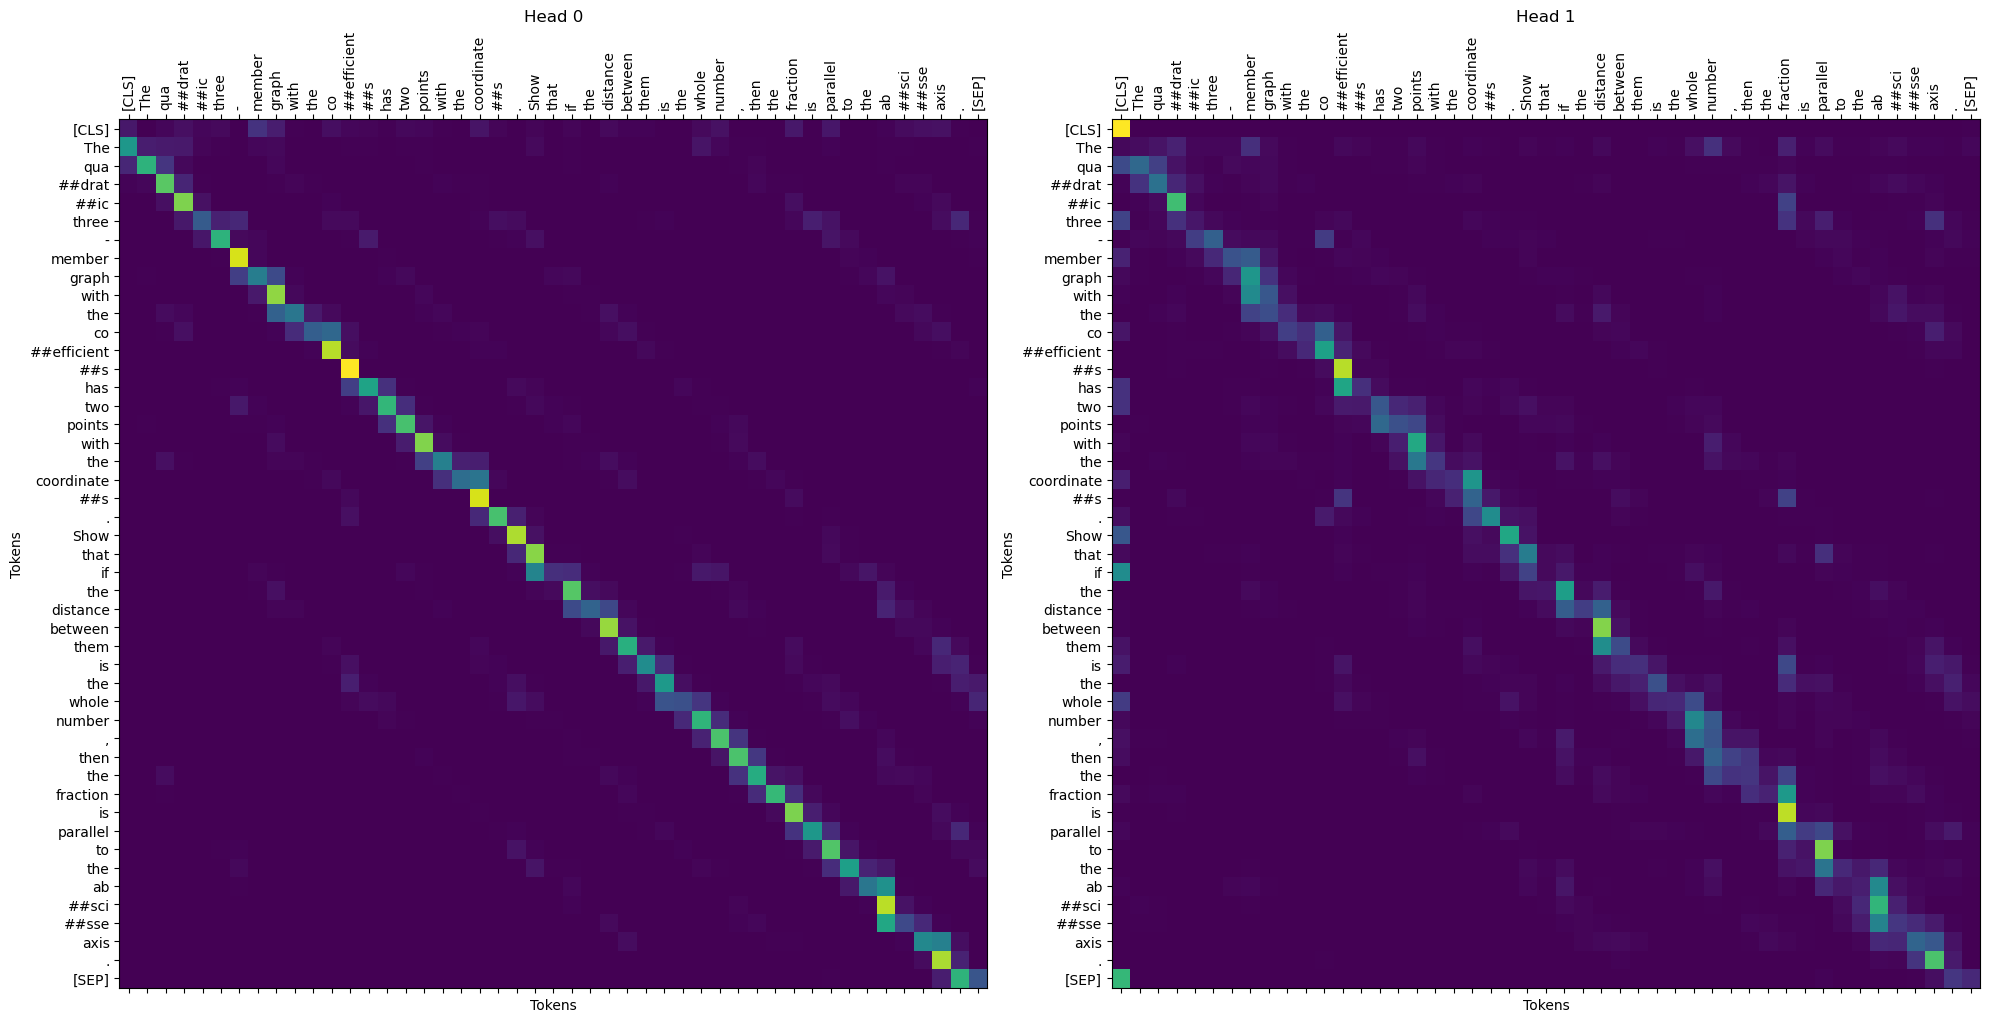

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


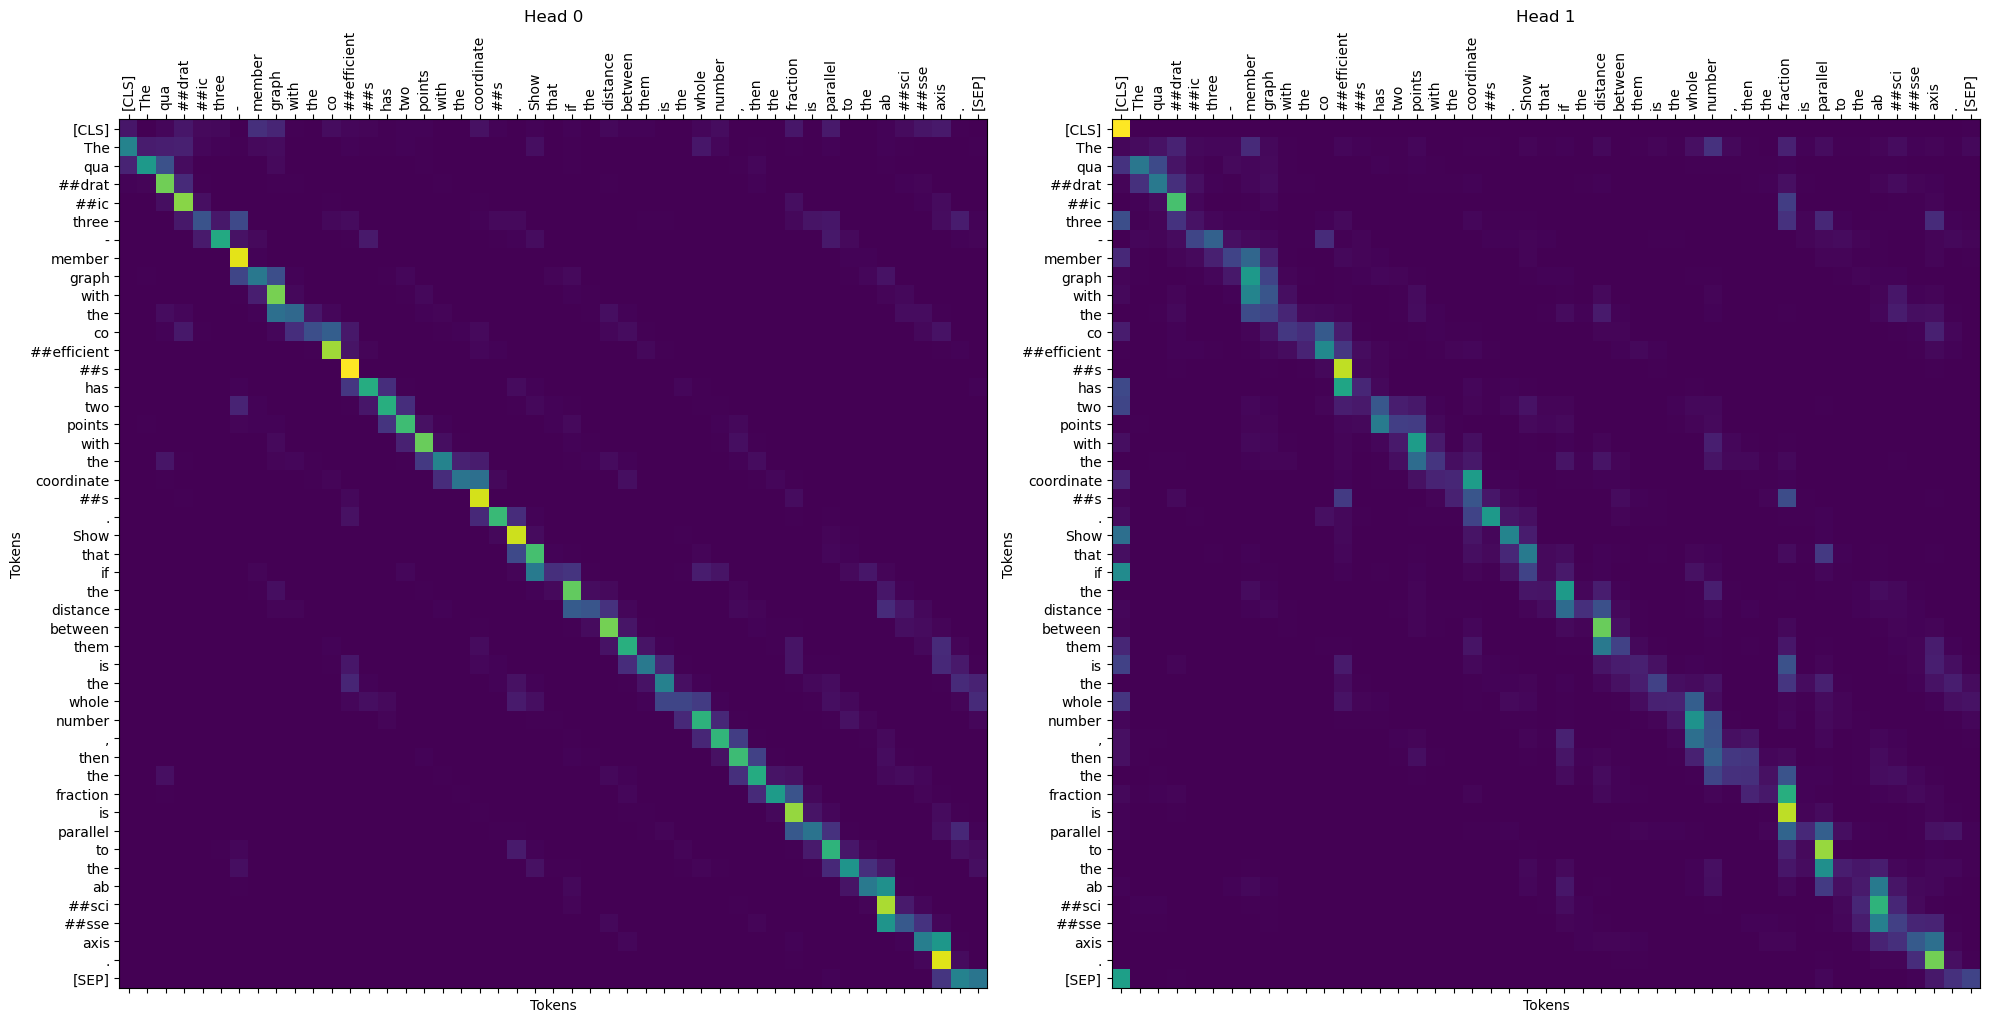

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


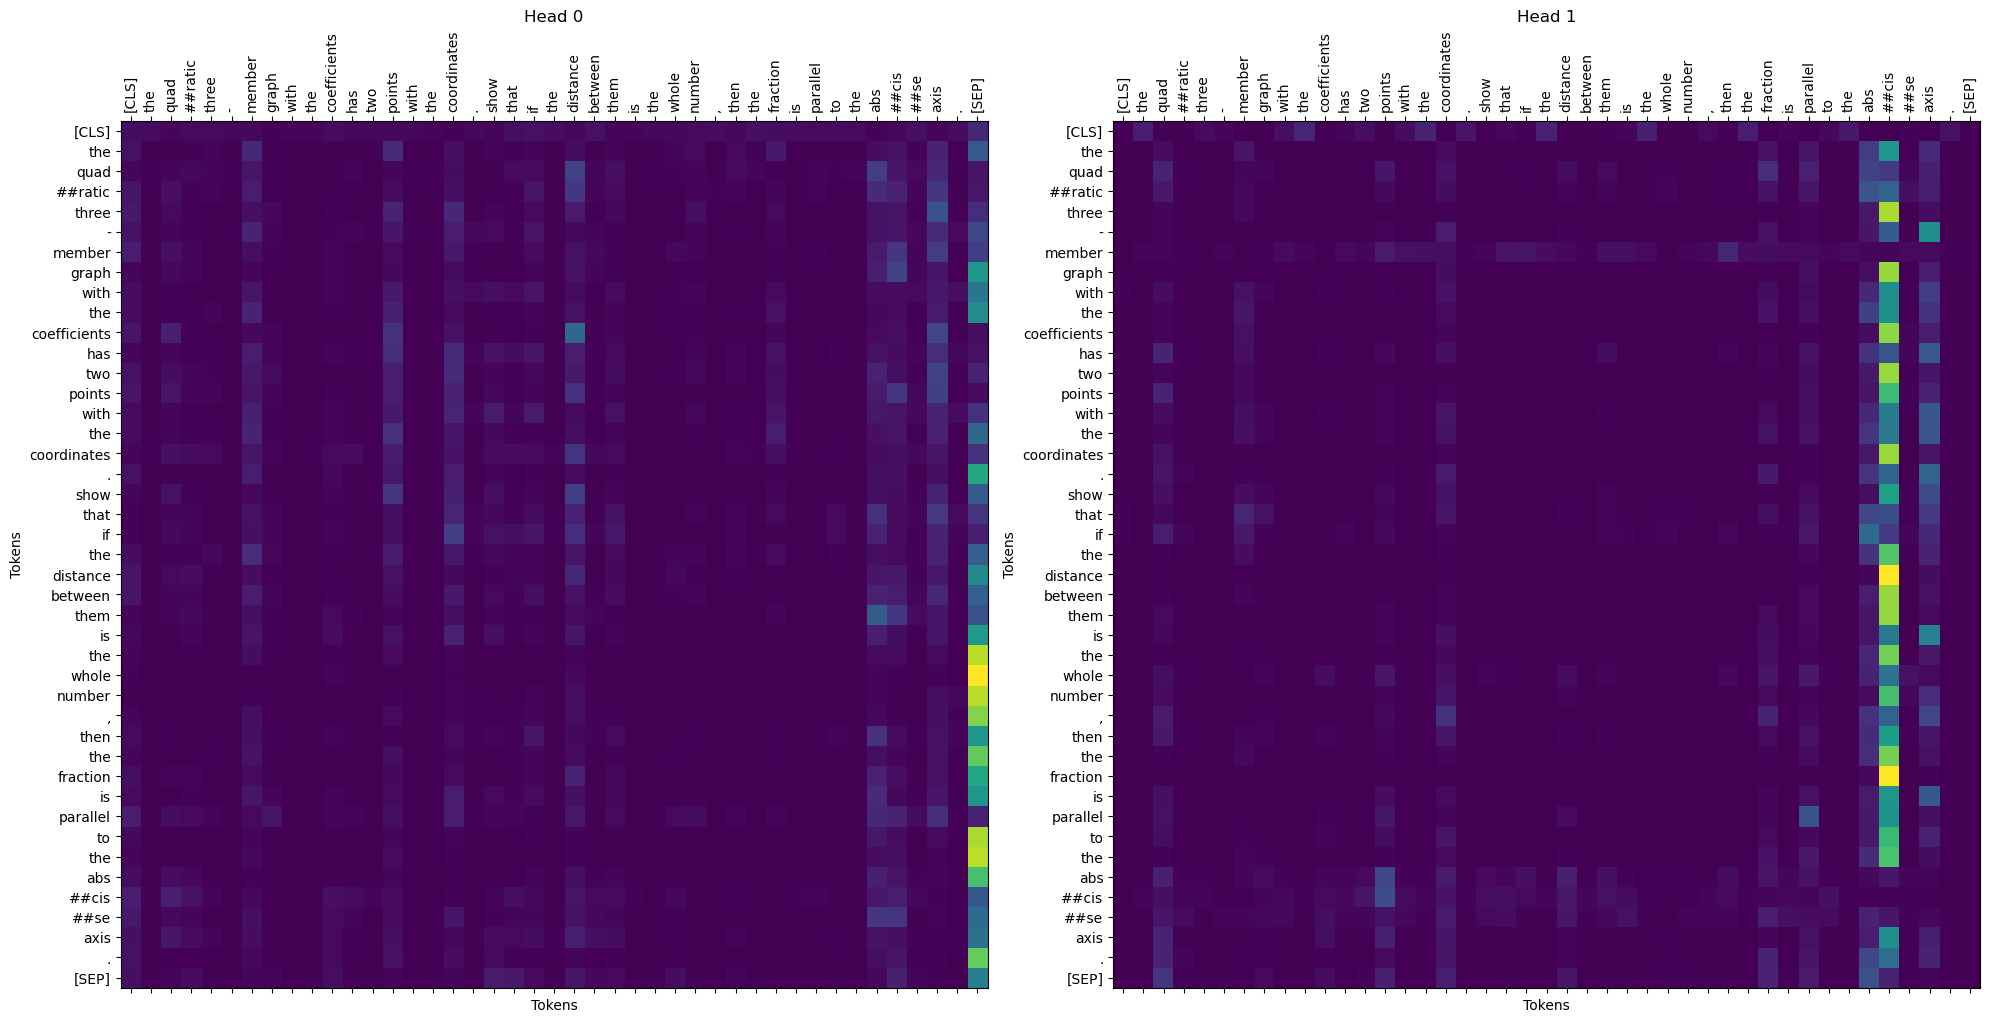

c:\Users\Katie\miniconda3\envs\mltest\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


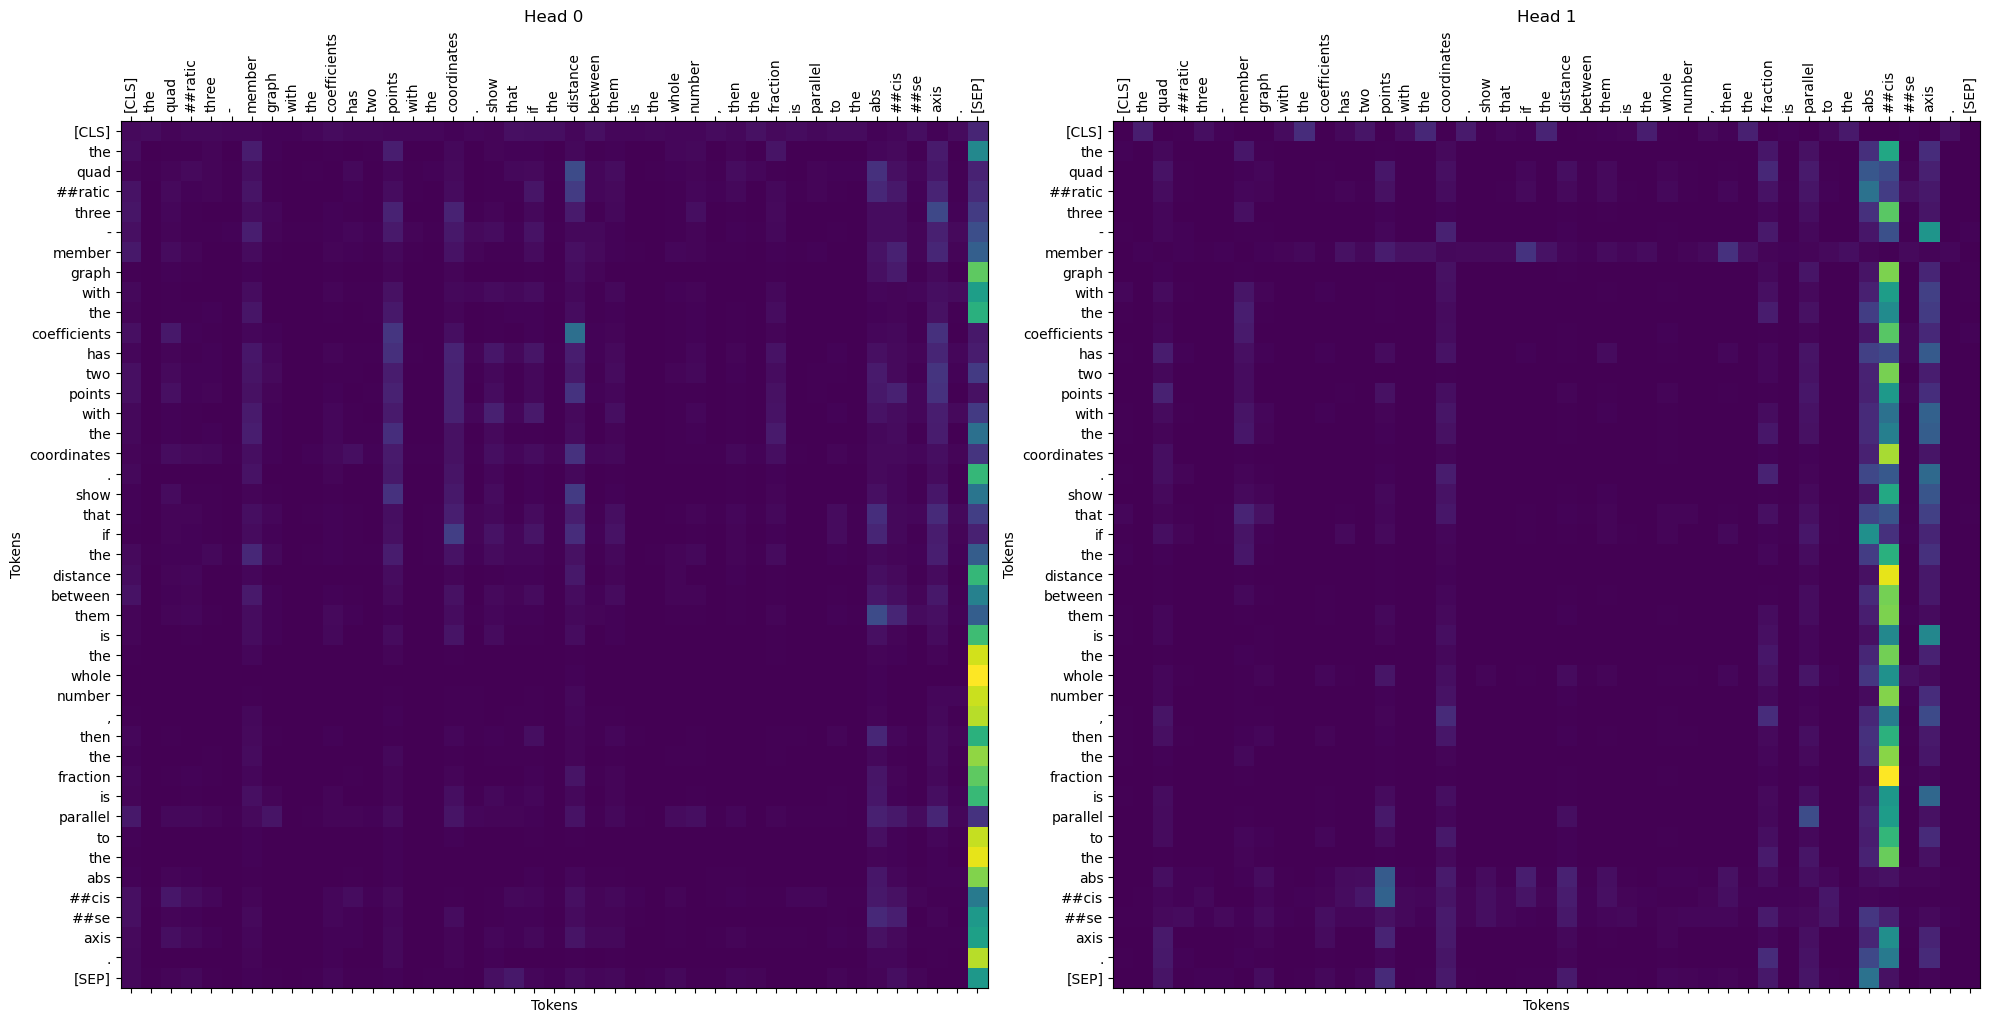

In [46]:
### YOUR CODE IS HERE

for text in texts_to_analyze:
    #draw_first_layer_attention_maps([0, 1], text, albert_base_v2__finetuned_with_freezed_backbone)
    #draw_first_layer_attention_maps([0, 1], text, albert_base_v2_full_finetuned)
    draw_first_layer_attention_maps([0, 1], text, rubert_tiny_finetuned_with_freezed_backbone)
    draw_first_layer_attention_maps([0, 1], text, rubert_tiny_full_finetuned)
    draw_first_layer_attention_maps([0, 1], text, math_bert_transformer_finetuned_with_freezed_backbone)
    draw_first_layer_attention_maps([0, 1], text, math_bert_transformer_full_finetuned)